In [1]:
%%html
<!-- definir quelques styles custom pour l'ensemble du notebook -->
<style>    
    @import url("css/custom_styles.css")
</style>

<center>
    <h1>
    Algorithmes d’apprentissage non supervisé<br>
    </h1>
    MovieLens - Système de recommendations de films<br>
    <br>
    <b>Jean-Francois Gagnon</b><br>
    <b>Michèle de La Sablonnière</b><br>
    <br>
    420-A58<br>
    <br>
</center>

# Introduction
    
Nous avons choisi la base de données [MovieLens Small](https://tinyurl.com/bdhmcfht). Elle décrit les notations des utilisateurs de MovieLens; un service de recommandations de films. Elle a été préalablement traité afin d'extraire les informations intéressantes pour un système de suggestions par *clusterisation* et règles d'associations. Les données pré-traitées se trouvent dans 2 fichiers. 

<br>**movies_pretraitement.csv**

Ce fichier contient les métadonnées pertinentes à un film. Chaque ligne a ce format :

<div class="indentation">
<div class="fixblock"> movieId, imdbId, title, year, year_category, year_boxcox_std, rating_mode, genres, genres_tfidf_*</div>

|Attribut|<center>Description</center>|
|:-|:---|
|movieId| Identifiant du film dans cette base de données.|
|imdbId| Identifiant du film dans [Internet Movie Database](http://www.imdb.com).|
|title| Titre du film. Peut contenir l'année de parution.|
|year| Année de parution du film.|
|year_category| **year** catégorisé. La base de données a 3 modalités.|
|year_boxcox_std| **year** transformé par BoxCox et StandardScaler.|
|rating_mode| Nombre d'étoiles attribuées avec une granularité de $\frac{1}{2}$. Entre [0.5 et 5] |
|genres| Liste de mots séparés par un 'pipe' (\|). La base de données a 18 modalités. |
|genres_tfidf_*| **genres** encodé selon TF-IDF. Ici l'étoile représente toutes les modalités de **genres**. |
</div>

<br>**ratings_pretraitement.csv**

Ce fichier contient les métadonnées de notations de chaque utilisateur. Chaque ligne a ce format :

<div class="indentation">
<div class="fixblock">userId, films*</div>

|Attribut|<center>Description</center>|
|:-|:---|
|userId| Identifiant de l'utilisateur.|
|films*| Notation de l'utilisateur pour un film. Ici l'étoile représente une colonne par film. |
</div>

<br>

Nous allons d'abord valider les prétraitements. Par la suite, dans un but de restreindre la portée du projet, nous allons faire une *clusterization* de 2 représentations de genres (**genres** et **genres_tfidf\***) et examiner 2 méthodes de réduction de dimensions pour chaque représentation. Finalement nous allons examiner les règles d'associations avec **ratings_pretraitement.csv**.

In [2]:
#
# imports utilitaires
#

%matplotlib inline

import base64
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from fanalysis.base import Base
from fanalysis.mca import MCA
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.stats import chi2_contingency
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from wordcloud import WordCloud
from matplotlib.ticker import MultipleLocator


#
# imports faisant partie de nos propres modules
#

import helpers as hlp
import helpers.Clustering as clstr
import helpers.jupyter as jup

# Lecture des données

In [3]:
#
# parametres configurant nos traitements
#
configs = hlp.get_configs("config_overrides.json")

# imdbId doit etre garde en string (leading 0)
movies_df = pd.read_csv("dataset/movies_pretraitement.csv", dtype={"imdbId": str})

print("Movies", movies_df.shape)
print("Head")
display(movies_df.head().round(2))
clstr.show_types(movies_df)

Movies (9460, 26)
Head


movieId   imdbId                               title  year year_category  \
0        1  0114709                    Toy Story (1995)  1995  [1975, 2001]   
1        2  0113497                      Jumanji (1995)  1995  [1975, 2001]   
2        3  0113228             Grumpier Old Men (1995)  1995  [1975, 2001]   
3        4  0114885            Waiting to Exhale (1995)  1995  [1975, 2001]   
4        5  0113041  Father of the Bride Part II (1995)  1995  [1975, 2001]   

   year_boxcox_std  rating_mode                                       genres  \
0            -0.19          4.0  Children|Adventure|Animation|Comedy|Fantasy   
1            -0.19          4.0                   Fantasy|Children|Adventure   
2            -0.19          3.0                               Romance|Comedy   
3            -0.19          3.0                         Drama|Romance|Comedy   
4            -0.19          3.0                                       Comedy   

   genres_tfidf_Action  genres_tfidf_Adventure  ...  genres_tfidf_Fantasy  \
0                  0.0                    0.41  ...                  0.48   
1                  0.0                    0.51  ...                  0.59   
2                  0.0                    0.00  ...                  0.00   
3                  0.0                    0.00  ...                  0.00   
4                  0.0                    0.00  ...                  0.00   

   genres_tfidf_Film-Noir  genres_tfidf_Horror  genres_tfidf_Musical  \
0                     0.0                  0.0                   0.0   
1                     0.0                  0.0                   0.0   
2                     0.0                  0.0                   0.0   
3                     0.0                  0.0                   0.0   
4                     0.0                  0.0                   0.0   

   genres_tfidf_Mystery  genres_tfidf_Romance  genres_tfidf_Sci-Fi  \
0                   0.0                  0.00                  0.0   
1                   0.0                  0.00                  0.0   
2                   0.0                  0.82                  0.0   
3                   0.0                  0.72                  0.0   
4                   0.0                  0.00                  0.0   

   genres_tfidf_Thriller  genres_tfidf_War  genres_tfidf_Western  
0                    0.0               0.0                   0.0  
1                    0.0               0.0                   0.0  
2                    0.0               0.0                   0.0  
3                    0.0               0.0                   0.0  
4                    0.0               0.0                   0.0  

[5 rows x 26 columns]

Types


movieId  imdbId   title   year year_category year_boxcox_std rating_mode  \
Type   int64  object  object  int64        object         float64     float64   

      genres genres_tfidf_Action genres_tfidf_Adventure  ...  \
Type  object             float64                float64  ...   

     genres_tfidf_Fantasy genres_tfidf_Film-Noir genres_tfidf_Horror  \
Type              float64                float64             float64   

     genres_tfidf_Musical genres_tfidf_Mystery genres_tfidf_Romance  \
Type              float64              float64              float64   

     genres_tfidf_Sci-Fi genres_tfidf_Thriller genres_tfidf_War  \
Type             float64               float64          float64   

     genres_tfidf_Western  
Type              float64  

[1 rows x 26 columns]

* 9460 individus 
* 26 variables (inclus les identifiants, elles correspondent bien à la description)
* **title**, **year_category** et **genres** sont de type qualitatif. Les autres variables sont de type quantitatif. Noter que **rating_mode** représente bien une variable qualitative par nature mais est gardée quantitative pour faciliter certaines manipulations.

# Doublons et valeurs manquantes

In [4]:
#
# validation doublons et valeurs manquantes 
#
print("Avant retrait doublons:", movies_df.shape)
movies_df.drop_duplicates(inplace=True)
print("Après retrait doublons:", movies_df.shape)

clstr.show_na(movies_df);

Avant retrait doublons: (9460, 26)
Après retrait doublons: (9460, 26)
Valeur manquante 0 (0.0%)


Aucun doublon et aucune valeur manquante. Nous allons vérifier les modalités des variables qualitatives.

In [5]:
#
# Verification des modalites (rating_mode est egalement inclu pour valider
# s'il correspond bien a sa description)
#
def get_mods(values, name=""):
    if isinstance(values, pd.Series):
        series = pd.Series(values.unique())
        series.name = values.name
    else:
        series = pd.Series(values)
        series.name = name
    
    return series.to_frame()

genres_ohe_df = movies_df.genres.str.get_dummies(sep=configs.dataset.genre_splitter)
genres_mods = get_mods(genres_ohe_df.columns, name="genres")

html_ = jup.horizontify(get_mods(movies_df.year_category),
                        get_mods(movies_df.rating_mode),
                        genres_mods)
print("Modalités")
jup.display_html(html_)

Modalités


# Distributions - variables quantitatives

Stats générales - variables quantitatives


count     mean    std      min      25%      50%  \
year                      9460.0  1994.64  18.38  1902.00  1988.00  1999.00   
year_boxcox_std           9460.0    -0.00   1.00    -2.68    -0.61     0.08   
rating_mode               9460.0     3.48   0.97     0.50     3.00     3.50   
genres_tfidf_Action       9460.0     0.11   0.23     0.00     0.00     0.00   
genres_tfidf_Adventure    9460.0     0.07   0.20     0.00     0.00     0.00   
genres_tfidf_Animation    9460.0     0.04   0.16     0.00     0.00     0.00   
genres_tfidf_Children     9460.0     0.04   0.16     0.00     0.00     0.00   
genres_tfidf_Comedy       9460.0     0.24   0.34     0.00     0.00     0.00   
genres_tfidf_Crime        9460.0     0.08   0.23     0.00     0.00     0.00   
genres_tfidf_Documentary  9460.0     0.04   0.20     0.00     0.00     0.00   
genres_tfidf_Drama        9460.0     0.27   0.34     0.00     0.00     0.00   
genres_tfidf_Fantasy      9460.0     0.05   0.17     0.00     0.00     0.00   
genres_tfidf_Film-Noir    9460.0     0.01   0.08     0.00     0.00     0.00   
genres_tfidf_Horror       9460.0     0.07   0.22     0.00     0.00     0.00   
genres_tfidf_Musical      9460.0     0.03   0.14     0.00     0.00     0.00   
genres_tfidf_Mystery      9460.0     0.04   0.16     0.00     0.00     0.00   
genres_tfidf_Romance      9460.0     0.12   0.27     0.00     0.00     0.00   
genres_tfidf_Sci-Fi       9460.0     0.07   0.20     0.00     0.00     0.00   
genres_tfidf_Thriller     9460.0     0.11   0.24     0.00     0.00     0.00   
genres_tfidf_War          9460.0     0.03   0.16     0.00     0.00     0.00   
genres_tfidf_Western      9460.0     0.01   0.11     0.00     0.00     0.00   

                              75%      max  
year                      2008.00  2018.00  
year_boxcox_std              0.79     1.78  
rating_mode                  4.00     5.00  
genres_tfidf_Action          0.00     1.00  
genres_tfidf_Adventure       0.00     1.00  
genres_tfidf_Animation       0.00     1.00  
genres_tfidf_Children        0.00     1.00  
genres_tfidf_Comedy          0.47     1.00  
genres_tfidf_Crime           0.00     1.00  
genres_tfidf_Documentary     0.00     1.00  
genres_tfidf_Drama           0.46     1.00  
genres_tfidf_Fantasy         0.00     1.00  
genres_tfidf_Film-Noir       0.00     1.00  
genres_tfidf_Horror          0.00     1.00  
genres_tfidf_Musical         0.00     1.00  
genres_tfidf_Mystery         0.00     1.00  
genres_tfidf_Romance         0.00     1.00  
genres_tfidf_Sci-Fi          0.00     1.00  
genres_tfidf_Thriller        0.00     1.00  
genres_tfidf_War             0.00     1.00  
genres_tfidf_Western         0.00     1.00


Distributions - variables quantitatives


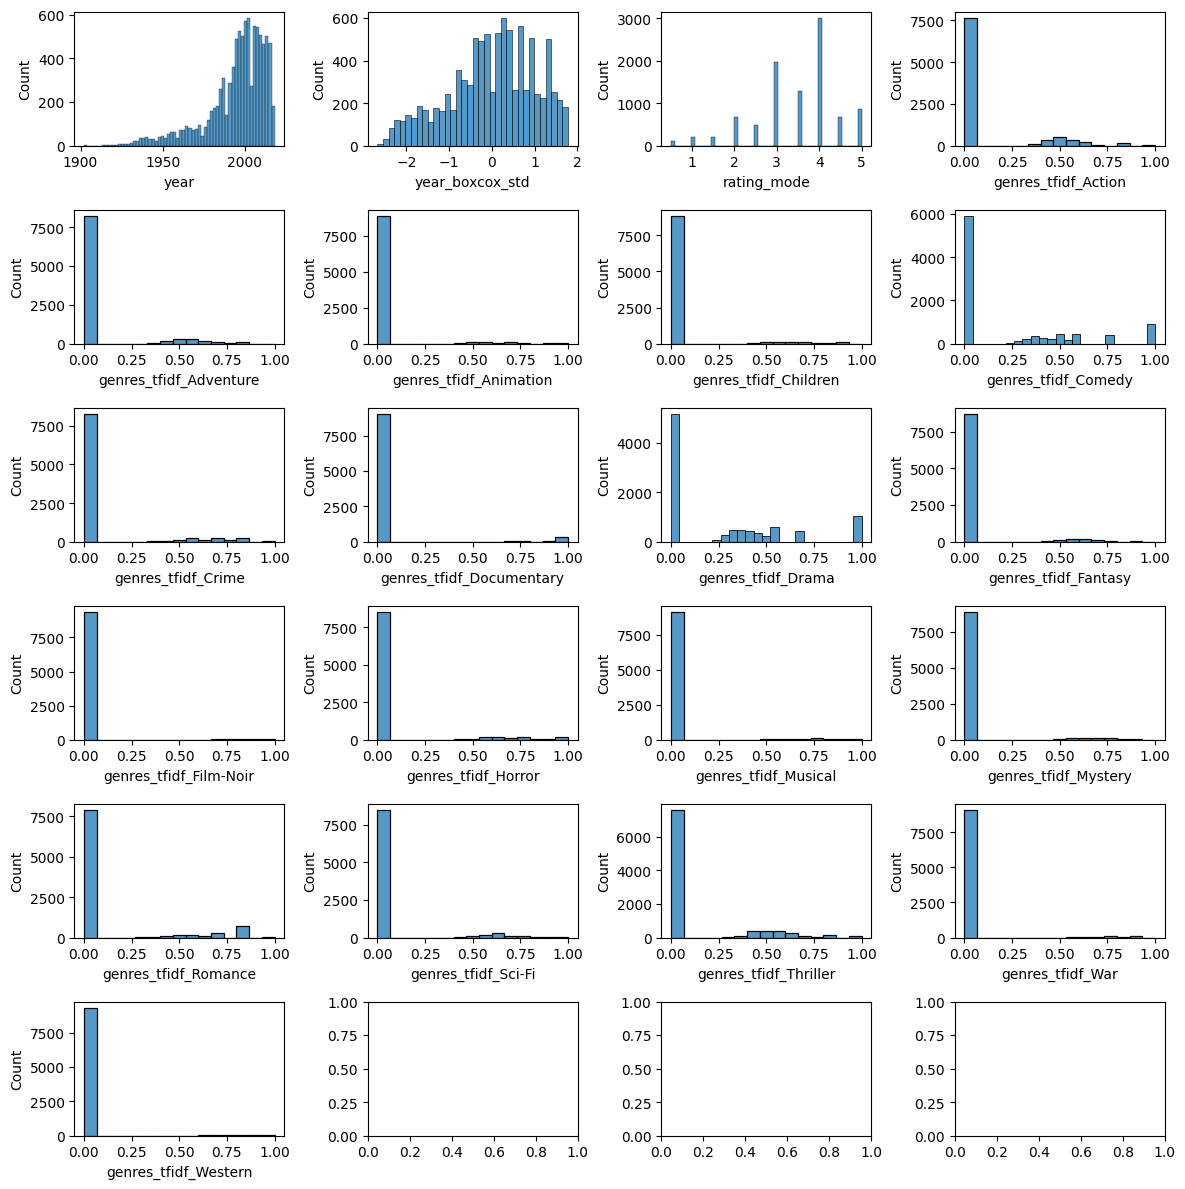

In [6]:
# on enleve movieId, imdbId et title
quant_df = movies_df.iloc[:, 3:].select_dtypes(exclude="object")

print("Stats générales - variables quantitatives")
display(quant_df.describe().T.round(2))
print()
print("Distributions - variables quantitatives")
clstr.show_distributions(quant_df, num_cols=4, figsize=(12, 12))

* **year** très allongée (queue à gauche)
* **year_boxcox_std** très près d'une distribution standard. Les statistiques générales nous montrent bien $\mu=0$ et $\sigma=1$. 
* **rating_mode**, bien qu'étant quantitative, montre bien sa nature qualitative.
* **genres_tfidf\*** ont des distributions très éparses (beaucoup de 0). Plus de détails dans les prochaines cellules.

# Valeurs aberrantes et *outliers* - variables quantitatives

IQR outliers par variable, eta: 1.5


year  year_boxcox_std  rating_mode  genres_tfidf_Action  \
Count  562.0              0.0        310.0               1818.0   
%        5.9              0.0          3.3                 19.2   

       genres_tfidf_Adventure  genres_tfidf_Animation  genres_tfidf_Children  \
Count                  1239.0                   573.0                  626.0   
%                        13.1                     6.1                    6.6   

       genres_tfidf_Comedy  genres_tfidf_Crime  genres_tfidf_Documentary  ...  \
Count                  0.0              1189.0                     428.0  ...   
%                      0.0                12.6                       4.5  ...   

       genres_tfidf_Fantasy  genres_tfidf_Film-Noir  genres_tfidf_Horror  \
Count                 758.0                    85.0                933.0   
%                       8.0                     0.9                  9.9   

       genres_tfidf_Musical  genres_tfidf_Mystery  genres_tfidf_Romance  \
Count                 334.0                 569.0                1562.0   
%                       3.5                   6.0                  16.5   

       genres_tfidf_Sci-Fi  genres_tfidf_Thriller  genres_tfidf_War  \
Count                964.0                 1871.0             375.0   
%                     10.2                   19.8               4.0   

       genres_tfidf_Western  
Count                 165.0  
%                       1.7  

[2 rows x 21 columns]


IQR outliers 7309 (77.3%), eta: 1.5

Outliers boxplots, eta: 1.5


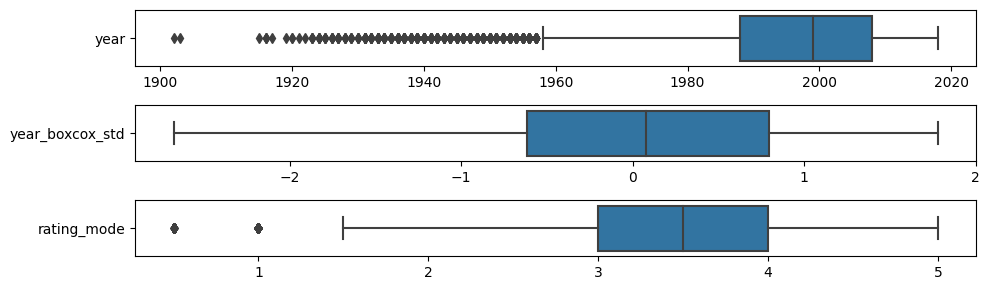

In [7]:
clstr.show_outliers_iqr(quant_df, 
                        eta=1.5,
                        boxlists=[[c] for c in quant_df.columns[:3]],
                        figsize=(10, 3));

IQR outliers par variable, eta: 1.5


genres_tfidf_Action  genres_tfidf_Adventure  genres_tfidf_Animation  \
Count                 61.0                    56.0                    27.0   
%                      0.6                     0.6                     0.3   

       genres_tfidf_Children  genres_tfidf_Comedy  genres_tfidf_Crime  \
Count                    0.0                  0.0                 2.0   
%                        0.0                  0.0                 0.0   

       genres_tfidf_Documentary  genres_tfidf_Drama  genres_tfidf_Fantasy  \
Count                      91.0                 0.0                   4.0   
%                           1.0                 0.0                   0.0   

       genres_tfidf_Film-Noir  genres_tfidf_Horror  genres_tfidf_Musical  \
Count                     2.0                  0.0                   0.0   
%                         0.0                  0.0                   0.0   

       genres_tfidf_Mystery  genres_tfidf_Romance  genres_tfidf_Sci-Fi  \
Count                   5.0                   0.0                 39.0   
%                       0.1                   0.0                  0.4   

       genres_tfidf_Thriller  genres_tfidf_War  genres_tfidf_Western  
Count                   81.0               0.0                   1.0  
%                        0.9               0.0                   0.0


IQR outliers 363 (3.8%), eta: 1.5

Outliers boxplots, eta: 1.5


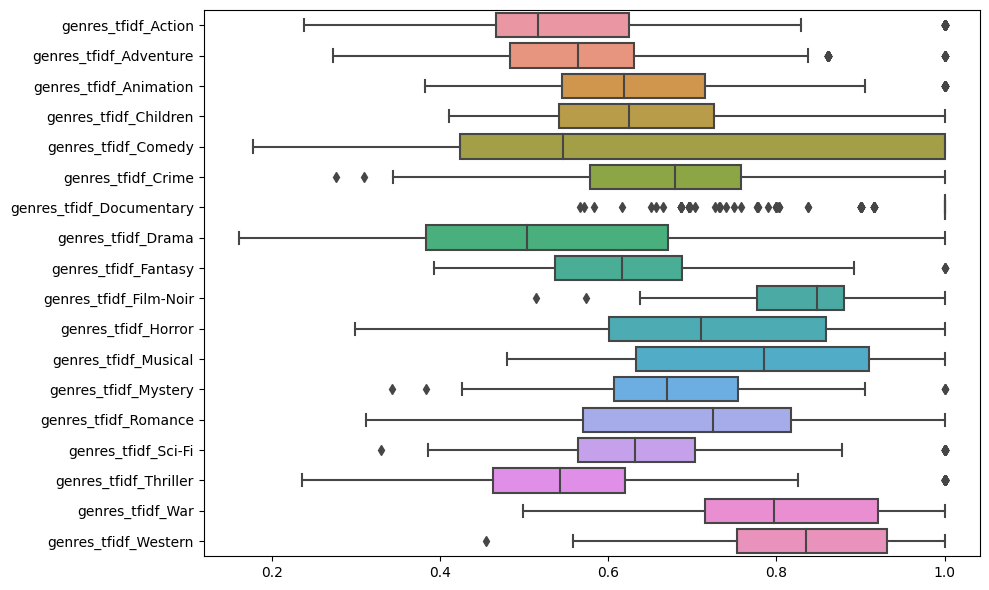

In [8]:
#
# retirer les 0 pour visualiser les genres_tfidf*
#
data_tmp = quant_df.iloc[:, 3:]
data_tmp = data_tmp[ data_tmp > 0 ]
clstr.show_outliers_iqr(data_tmp, 
                        eta=1.5,
                        boxlists=[data_tmp.columns],
                        figsize=(10, 6));

* **year** a beaucoup d'*outliers* mais **year_boxcox_std** les ramène sous contrôle.
* **rating_mode** ne possède pas d'*outliers* à notre avis. 0.5 et 1 sont des valeurs légitimes et les distributions affichées plus haut montrent qu'il y en a très peu.
* **genres_tfidf\*** ne possède pas d'*outliers* à notre avis de part sa nature éparse. Les 0 marquent l'absence du genre dans certains films. Les 1 marquent quant à eux la présence d'un seul genre dans les films. Nous pensons qu'il est plus pertinent d'utiliser **genres_tfidf\*** à part et non en conjonction avec d'autres variables.

# Distributions - variables qualitatives

Distributions - variables qualitatives


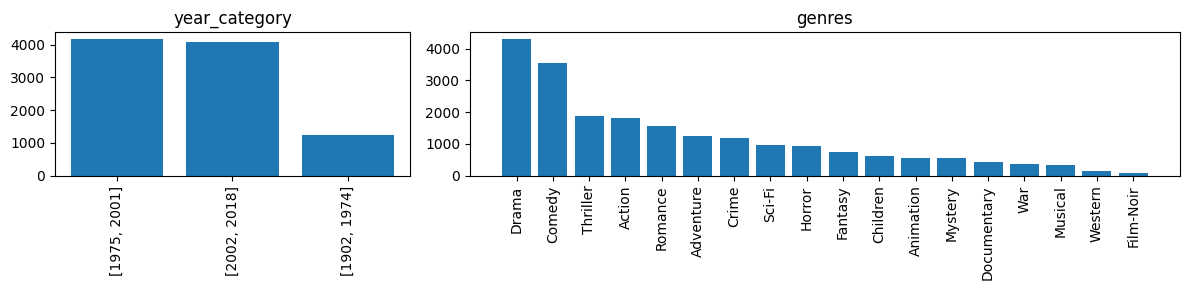

In [9]:
year_category_count = movies_df.year_category.value_counts()
genres_count = genres_ohe_df.sum(axis=0)
genres_count.sort_values(ascending=False, inplace=True)

print("Distributions - variables qualitatives")

_, axes = plt.subplots(1, 
                       2, 
                       width_ratios=[1, 2],
                       figsize=(12, 3))
axes[0].bar(year_category_count.index, year_category_count)
axes[0].tick_params(axis="x", labelrotation=90)
axes[0].set_title("year_category")

axes[1].bar(genres_count.index, genres_count)
axes[1].tick_params(axis="x", labelrotation=90)
axes[1].set_title("genres")
             
plt.tight_layout()
plt.show()

* **year_category** est très bien balancé si on ne tient pas compte de [1902, 1974]
* **genres** a une forte proportion dans les modalités Drama et Comedy

# Corrélation

In [10]:
#
# utilitaires pour calculer chi2 (correlation avec variables qualitatives)
#
def genres_contingency(b, data, genres_modalites):
    """
    Utilitaire pour calculer la table de contingence sachant que genres est implique
    Pandas.crosstab() ne fonctionne pas avec genres
    """
    def _genres_crit(data, modality):
        return data.str.contains(fr"\b{modality}\b", case=True, regex=True)
    
    def _default_crit(data, modality):
        return data == modality
    
    if b == "genres":
        other_crit_ = _genres_crit
        other = data.genres
        other_modalities = genres_modalites
    else:
        other_crit_ = _default_crit
        other = data[b]
        other_modalities = other.unique()
    
    ct = pd.DataFrame(0, 
                      index=genres_modalites, 
                      columns=other_modalities)

    for m0 in genres_modalites:
        genres_crit = _genres_crit(data.genres, m0)
        
        for m1 in other_modalities:
            other_crit = other_crit_(other, m1)
            ct.loc[m0, m1] = np.count_nonzero(genres_crit & other_crit)
        
    return ct

def chi2(a, b, df, genres_modalites):
    """
    Encapsule le calcul de chi2 pour tenir compte de genres
    """
    if a == "genres":
        contingency = genres_contingency(b, df, genres_modalites)
    elif b == "genres":
        contingency = genres_contingency(a, df, genres_modalites).T
    else:
        contingency = pd.crosstab(df[a], df[b])
        
    chi2_, pvalue, _, _ = chi2_contingency(contingency)
    return chi2_, pvalue

def chi2_analysis(data, chi2_columns, genres_modalites):
    """
    Encapsule analyse chi2. Assumer que chi2_columns ne contient que 
    des variables qualitatives.
    """
    chi2_df = pd.DataFrame(np.nan, 
                           index=chi2_columns, 
                           columns=chi2_columns)
    chi2_pvalue_df = pd.DataFrame(np.nan, 
                                  index=chi2_columns, 
                                  columns=chi2_columns)

    for c0 in chi2_columns:
        for c1 in chi2_columns:
            prev = chi2_df.loc[c1, c0]
            if math.isnan(prev):
                prev, prev_pvalue = chi2(c0, 
                                         c1, 
                                         data,
                                         genres_modalites)
            else:
                prev_pvalue = chi2_pvalue_df.loc[c1, c0]

            chi2_df.loc[c0, c1] = prev
            chi2_pvalue_df.loc[c0, c1] = prev_pvalue

    chi2_styler = jup.caption_df(chi2_df.style, r"$\chi^2$", caption_bold=False)
    pvalue_styler = jup.caption_df(chi2_pvalue_df.style, "$p_{value}$", caption_bold=False)
    corr_html = jup.horizontify(chi2_styler, pvalue_styler)

    print("Analyse indépendance de:", chi2_columns)
    jup.display_html(corr_html)

In [11]:
chi2_analysis(movies_df,
              ["year_category", "rating_mode", "genres"], 
              genres_mods.genres)

Analyse indépendance de: ['year_category', 'rating_mode', 'genres']


On voit que $p_{value}$ est < 0.05. On rejète l'hypothèse nulle (indépendance). Les variables sont donc dépendantes. On assume par conséquent que clustering peut avoir un certain sens.

Corrélation genres tfidf


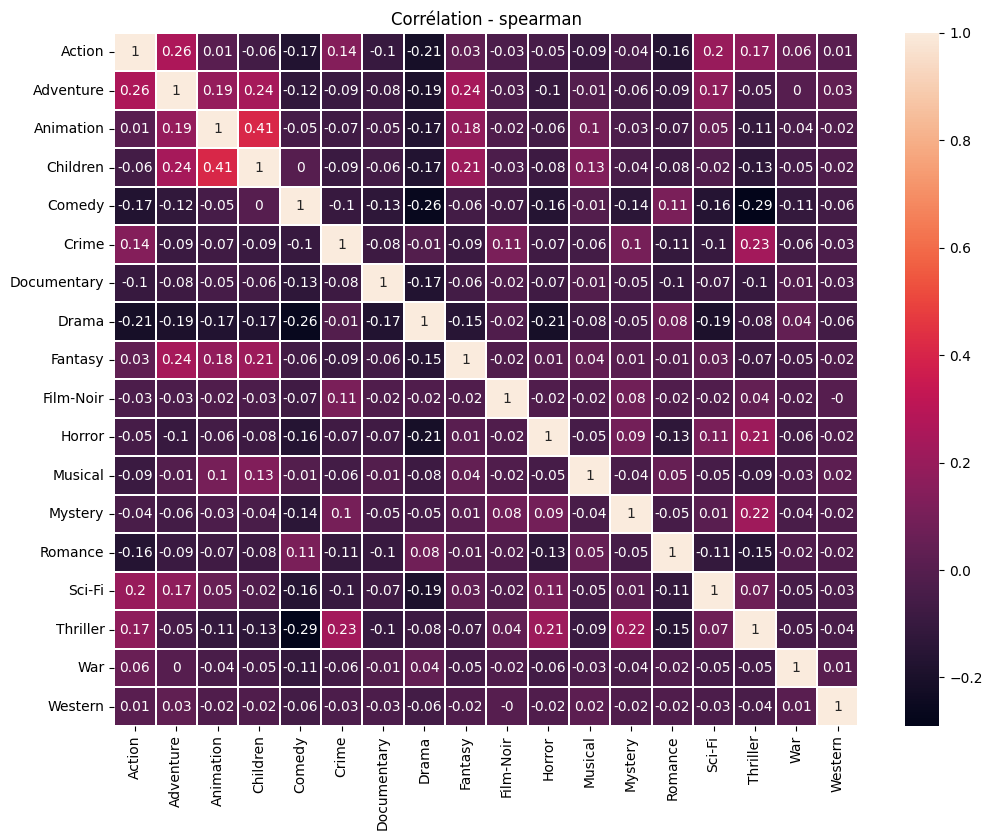

In [12]:
genres_tfidf_cols = movies_df.columns.str.contains("genres_tfidf_")
genres_tfidf_cols = movies_df.columns[genres_tfidf_cols]
genres_tfidf_df = movies_df[genres_tfidf_cols].copy()
genres_tfidf_df.columns = [c.replace("genres_tfidf_", "") for c in genres_tfidf_cols]

print("Corrélation genres tfidf")
clstr.show_correlation(genres_tfidf_df,
                       method="spearman", 
                       figsize=(12, 9))

La corrélation selon Spearman a été utilisé pour éliminer l'effet des 0. On n'observe aucune corrélation à toute fin pratique (majorités des valeurs < |0.2|) même si certaines modalités semblent exhiber un lien entre elles (Children et Animation).

On pourrait croire que la réduction de dimension ne serait pas utile mais, encore une fois, noter la présence de beaucoup de 0 dans les distributions. Nous allons donc valider plus loin dans le notebook ce constat.

Nous allons diminuer la quantité de données afin d'alléger le temps d'itération. Ceci peut de toute évidence biaiser les résultats mais nous croyons que cela est contrebalancé par l'utilisation de la bonne quantité de données.

In [13]:
#
# diminuer la quantite de donnes a traiter par souci de temps d'iteration
#
movies_original_df = movies_df
genres_ohe_original_df = genres_ohe_df
genres_tfidf_original_df = genres_tfidf_df

In [14]:
SAMPLING_FRAC = 0.3

movies_df = movies_original_df.sample(frac=SAMPLING_FRAC, random_state=42)
genres_ohe_df = genres_ohe_original_df.loc[movies_df.index]
genres_tfidf_df = genres_tfidf_original_df.loc[movies_df.index]

print("Avant resampling:", movies_original_df.shape)
print("Apres resampling:", movies_df.shape)

Avant resampling: (9460, 26)
Apres resampling: (2838, 26)


# Réduction de dimensions et *clustering*
## genres ACM

Genres se représente bien avec un encodage one hot. Une analyse en composante multiple (ACM) se prête donc à la réduction de dimensions.

In [15]:
#
# l'encodage de genres ne peut se faire par fanalysis
# fanalysis ne permet pas non plus fournir notre propre encodage
# donc, ajouter ces classes pour faire un pont dans le manque de fonctionnalite
#
class MCA_from_dummies(Base):
    def __init__(self, n_components=None, row_labels=None, var_labels=None, stats=True):
        Base.__init__(self, n_components, row_labels, None, stats)
        self.var_labels = var_labels
        
    def prefit(self, X, X_dummies):
        # Set columns prefixes
        self.n_vars_ = X.shape[1]
        self.prefixes_ = self.prefixes_ = [str(x) + "_" for x in self.var_labels]
        self.col_labels_short_temp_ = [x.split("_")[-1] for x in X_dummies.columns]
        self.col_labels_temp_ = X_dummies.columns
                
        # Dummy variables creation
        self.n_categories_ = X_dummies.shape[1]
    
    def fit(self, X_dummies, y=None):
        # Fit a Factorial Analysis to the dummy variables table
        self.r_ = np.sum(X_dummies, axis=1).reshape(-1, 1)
        Base.fit(self, X_dummies, y=None)
        
        # Adjustment of the number of components
        n_eigen = self.n_categories_ - self.n_vars_
        if (self.n_components_ > n_eigen):
            self.n_components_ = n_eigen
            self.eig_ = self.eig_[:, :self.n_components_]
            self.row_coord_ = self.row_coord_[:, :self.n_components_]
            self.col_coord_ = self.col_coord_[:, :self.n_components_]
            if self.stats:
                self.row_contrib_ = self.row_contrib_[:, :self.n_components_]
                self.col_contrib_ = self.col_contrib_[:, :self.n_components_]
                self.row_cos2_ = self.row_cos2_[:, :self.n_components_]
                self.col_cos2_ = self.col_cos2_[:, :self.n_components_]

        # Set col_labels_short_
        self.col_labels_short_ = self.col_labels_short_temp_
        
        # Set col_labels_
        self.col_labels_ = self.col_labels_temp_        
        
        self.model_ = "mca"
        
        return self
                        
def acm_init(data, n_components, data_dummies=None):
    if data_dummies is None:
        acm = MCA(n_components=n_components,
                  row_labels=data.index,
                  var_labels=data.columns)
        acm.fit(data.to_numpy())
    else:
        acm = MCA_from_dummies(n_components=n_components,
                               row_labels=data.index,
                               var_labels=data.columns)
        
        acm.prefit(data, data_dummies)        
        acm.fit(data_dummies.to_numpy())
    
    return acm

def acm_analysis(data, data_dummies=None, figsize=(4, 2.5)):
    """
    Le threshold est ~60% sur cumul var. expliquee
    """
    acm = acm_init(data, None, data_dummies=data_dummies)

    threshold = 1 / acm.n_vars_
    eig_vals = acm.eig_[0]
    eig_th = eig_vals[eig_vals > threshold]

    print("Valeurs propres:")
    print(acm.eig_[0].round(4))
    print()
    print(f"Valeurs propres > {round(threshold, 4)} (1 / p):")
    print(eig_th.round(4))
    print()
    print("Variance expliquee %:")
    print(acm.eig_[1].round(1))
    print()
    print("Variance expliquee cumul. %:")
    print(acm.eig_[2].round(1))
    print()

    num_eigval = len(acm.eig_[0])

    plt.figure(figsize=figsize)
    plt.plot(range(1, num_eigval + 1), acm.eig_[0], marker=".")
    plt.grid(True)
    plt.xlabel("# axe factoriel")
    plt.ylabel("Valeur propre")
    plt.show()

Valeurs propres:
[0.8939 0.635  0.5909 0.4905 0.4568 0.426  0.4036 0.3693 0.3556 0.3436
 0.2889 0.2758 0.2638 0.2235 0.2125 0.2065 0.1664]

Valeurs propres > 1.0 (1 / p):
[]

Variance expliquee %:
[13.5  9.6  8.9  7.4  6.9  6.5  6.1  5.6  5.4  5.2  4.4  4.2  4.   3.4
  3.2  3.1  2.5]

Variance expliquee cumul. %:
[ 13.5  23.2  32.1  39.5  46.5  52.9  59.   64.6  70.   75.2  79.6  83.8
  87.7  91.1  94.4  97.5 100. ]



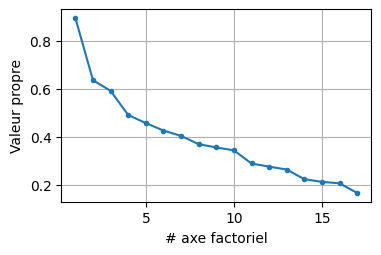

In [16]:
cluster_data_df = movies_df[["genres"]]
cluster_data_ohe_df = genres_ohe_df

acm_analysis(cluster_data_df, data_dummies=cluster_data_ohe_df)

La règle de Kaiser adaptée à l'ACM ne fonctionne pas ici (aucune valeur propre $\ge$ 1/1, p=1). Le graphe montre plusieurs coudes/plateaux (2, 7 et 10 axes factoriels). La variance expliquée cumulative nous permet de choisir 10 axes (~75% variance expliquée).

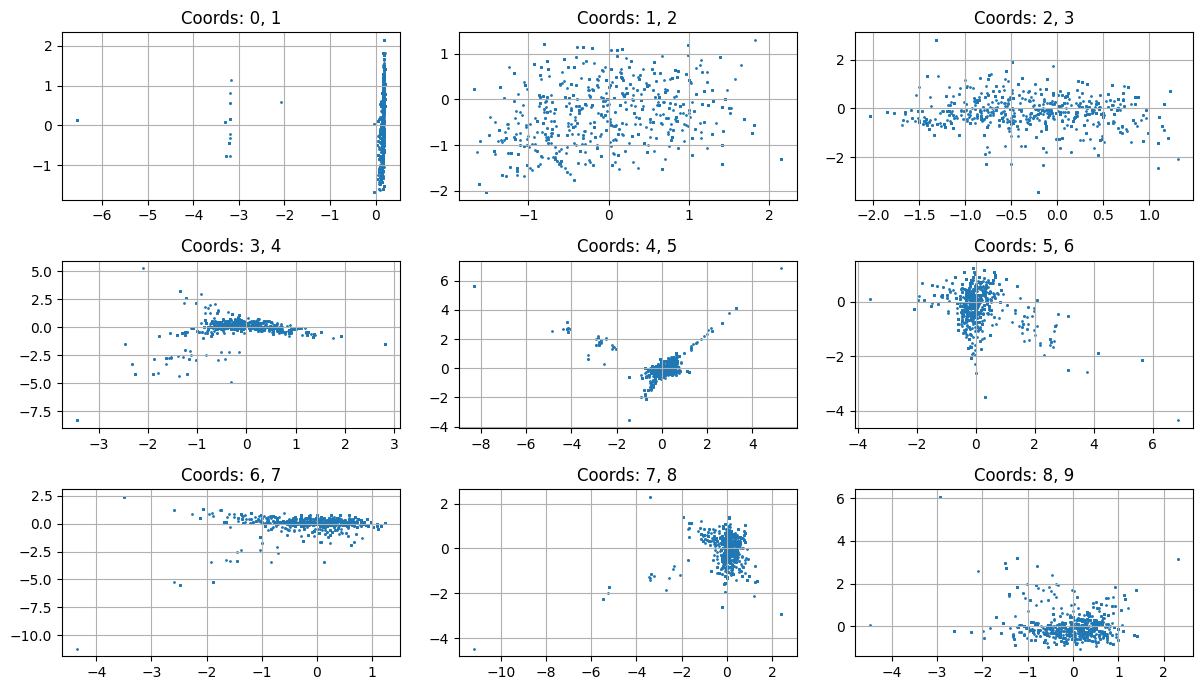

In [17]:
acm_ = acm_init(cluster_data_df, 10, data_dummies=cluster_data_ohe_df)

jup.display_html("<b>genres ACM</b> - Visualisation dimensions (non exhaustif)")
clstr.scatter_multiplot(acm_.row_coord_, num_cols=3, figsize=(12, 7), marker_size=1)

On remarque certaines structures qui se détachent, ce qui laisse présager que le *clustering* est possible. Notez que les structures ne sont pas globluaires et non consistantes à travers les dimensions. Nous suspectons que KMeams ne sera pas plus efficace que la classification ascendante hiérarchique (CAH). Dans le même ordre d'idée, la densité des points ne laisse pas présager que DBSCAN soit supérieur non plus.

## genres ACM - CAH

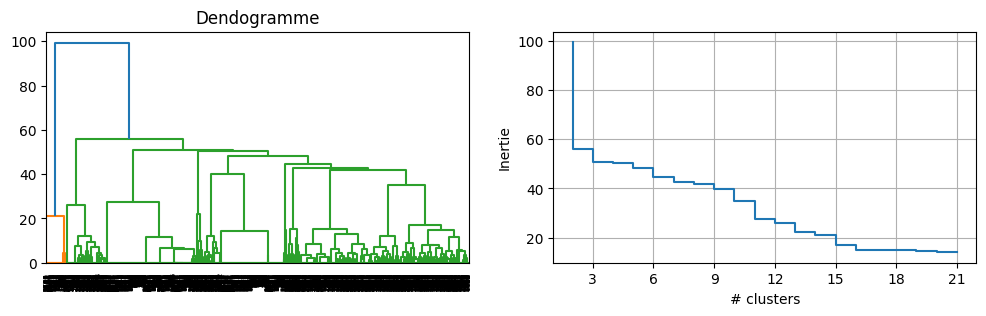

In [18]:
#
# etape longue (~40s) sans feedback visuel; soyez patient
#
clstr.cah_analysis(acm_.row_coord_, figsize=(12, 3))

On remarque un faible coude à 11 *clusters*. Si on coupe à la moitié de du gain maximum en inertie entre les *clusters* on arrive à environ 60-70 ce qui donne environ 5 *clusters*. Nous allons prendre le faible coude à 11 *clusters*

In [19]:
#
# fonctions utlitaires pour analyser contenu des clusters
#
def clusters_ohe_agg(group):
    return group.sum(axis=0)

def topmost_genres(group, count):
    group_no_zero = group[group > 0]

    # negatif pour avoir argsort() decroissant ET respecter ordre dans groupe
    group_no_zero = -group_no_zero
        
    topmost = group_no_zero.argsort()[:count]
    topmost = group_no_zero.index[topmost].to_list()
    topmost = "<br>".join(topmost)
    
    return pd.Series({f"{count} topmost genres": topmost})

def topmost_movies(group, labels, count):
    cluster_crit = labels == group.name
    movies = movies_df[cluster_crit] \
                .sort_values(by=["rating_mode", "year"], ascending=[False, False]) \
                .head(count)
    
    def _imdb_link(movie):
        return f"<a href='{configs.web_scraping.imdb_url}{movie.imdbId}'>{movie.title}</a>"
    
    links = movies.apply(_imdb_link, axis=1)
    links = "<br>".join(links)
    return pd.Series({f"{count} topmost movies": links})

def word_clouds(cluster):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        
        cluster_no_zero = cluster[cluster > 0]
        wc = WordCloud(width=300, height=100).generate_from_frequencies(cluster_no_zero)
        
    return pd.Series({"word_cloud": wc.to_array()})
    
def image_to_html(img):
    _, img = cv2.imencode(".png", img)
    return f"<img src='data:image/png;base64,{base64.b64encode(img).decode()}'>"
    
def clusters_analysis(ohe_df, 
                      labels, 
                      show_clusters_agg=False, 
                      head_count=0,
                      genres_count=5,
                      movies_count=8):
    clusters_agg_df = ohe_df.groupby(labels).agg(clusters_ohe_agg)
    if show_clusters_agg:
        display(clusters_agg_df)

    topmost_genres_df = clusters_agg_df.apply(topmost_genres, 
                                              axis=1, 
                                              count=genres_count)
    word_clouds_df = clusters_agg_df.apply(word_clouds, axis=1)
    topmost_movies_df = clusters_agg_df.apply(topmost_movies,
                                              axis=1, 
                                              labels=labels,
                                              count=movies_count)
    
    clusters_df = pd.concat([topmost_genres_df, 
                             word_clouds_df,
                             topmost_movies_df], axis=1)
    clusters_df.index.name = "cluster"
    
    if head_count > 0:
        clusters_df = clusters_df.head(head_count)

    html_ = clusters_df.to_html(formatters={"word_cloud": image_to_html}, escape=False)
    jup.display_html(html_)

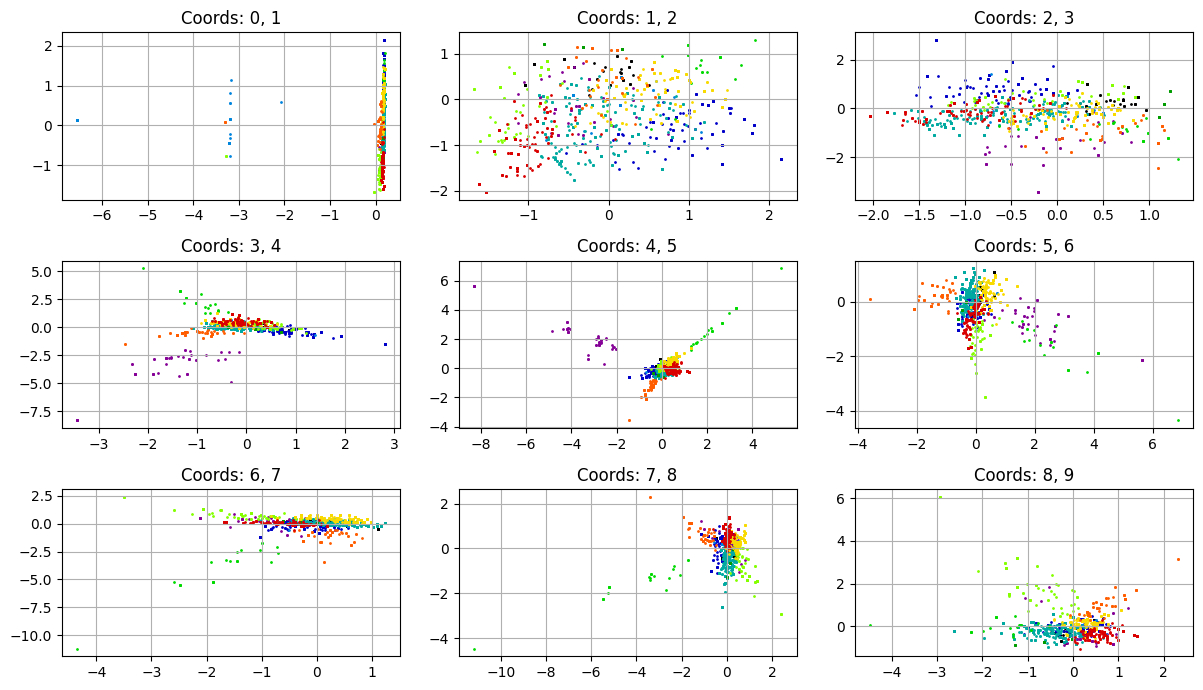

Davies Bouldin score: 0.8281

Silhouette score: 0.4225
Silhouette score par cluster
[0.4499, 0.3657, 0.2712, 0.7731, 0.1363, 0.7861, 0.4613, 0.3073, 0.3331, 0.4691, 0.4335]




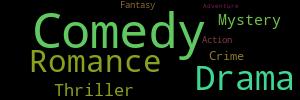
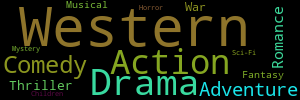
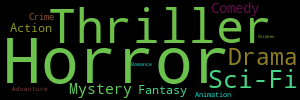
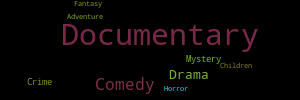
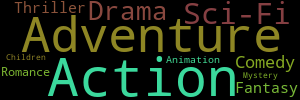
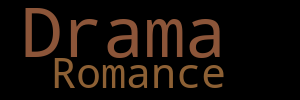
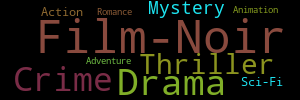
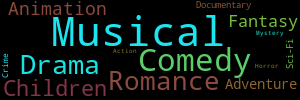
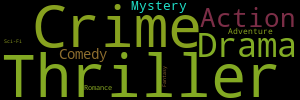
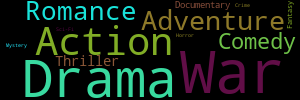
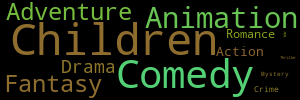

In [20]:
cah_ = clstr.cah_init(acm_.row_coord_, 11)

jup.display_html("<b>genres ACM</b> - Visualisation dimensions (non exhaustif) CAH")
clstr.scatter_multiplot(acm_.row_coord_, 
                        num_cols=3, 
                        figsize=(12, 7), 
                        marker_size=1, 
                        labels=cah_.labels_)

jup.display_html("<b>genres ACM</b> - Analyse clusters CAH\n")
clstr.clusters_analysis(acm_.row_coord_, cah_.labels_)
clusters_analysis(cluster_data_ohe_df, cah_.labels_)

La visualisation par graphe suggère que les *clusters* sont plutôt mal définis; longs et peu compacts. Le score Davies Bouldin élevé ainsi que les scores silhouette petits (en général plus petit que 0.5 sauf pour quelques clusters) corroborent ce constat. Par contre, en regardant le *clustering* à travers les données d'origine, on peut remarquer une séparation tout de même logique. L'examen détaillé montre :
* Le *cluster* 5 manque de précision.
* Le *cluster* 7 contient certains éléments non reliés aux comédies musicales.
  
(**Attention les *clusters* et les suggestions peuvent changer selon la quantité de données prises avant l'analyse**)

En général, 11 *clusters* nous apparait un peu petit pour la quantité de données présentes.

## genres ACM - KMeans

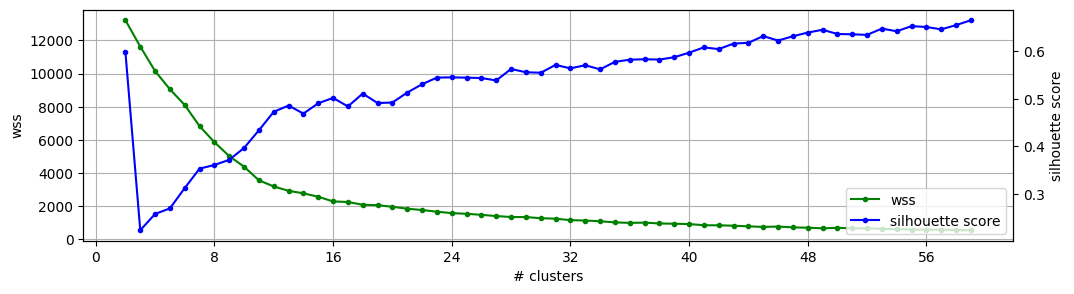

In [21]:
#
# etape longue (~20 secondes) sans feedback visuel; soyez patient
#
clstr.kmeans_analysis(acm_.row_coord_, 
                      clusters_range=range(2, 60),
                      n_init=5, # pour accelerer le traitement
                      figsize=(12, 3))

Le score silhouette va systématiquement en augmentant. Nous devons donc utiliser la méthode du coude avec l'inertie (wss) pour déterminer un nombre raisonable de *clusters*. Nous estimons que la zone du coude se situe entre 11 et 16 *clusters*. Nous en prenons donc 16; un peu plus que CAH et score silhouette maximale.

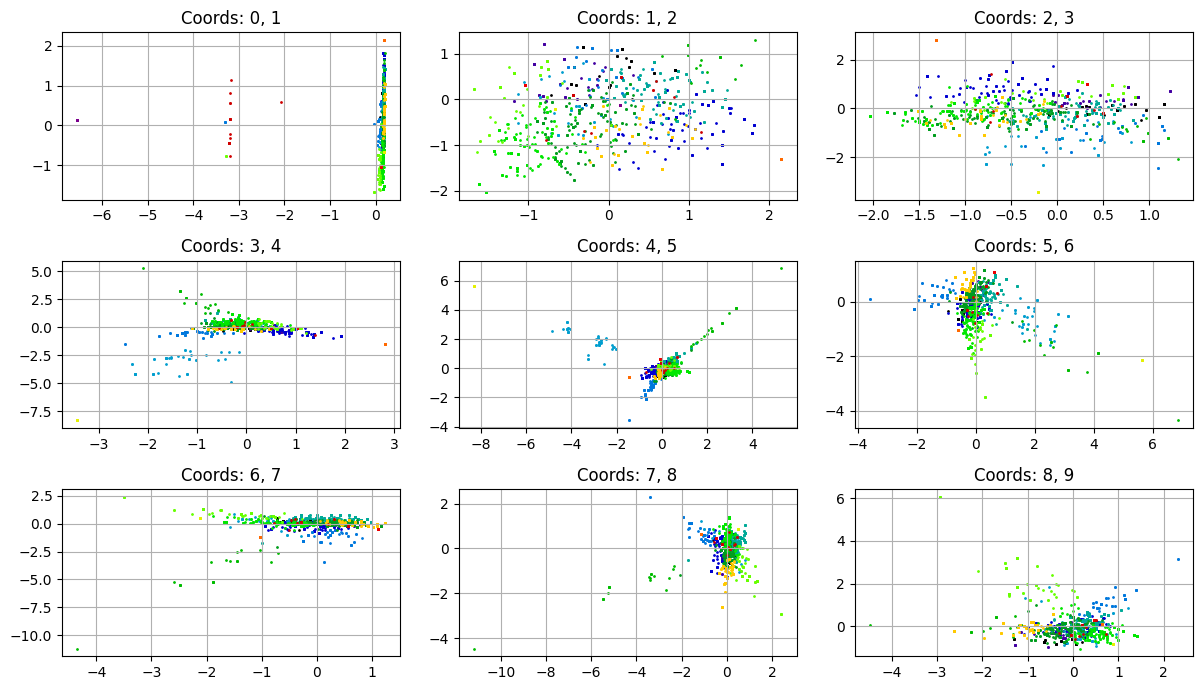

Davies Bouldin score: 0.7515

Silhouette score: 0.5015
Silhouette score par cluster
[0.6173, 1.0, 0.5402, 0.319, 0.4809, 0.4838, 0.3271, 0.1122, 0.5372, 0.3668, 0.3626, 1.0, 0.3241, 1.0, 1.0, 0.5955]




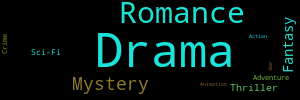
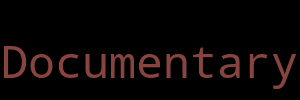
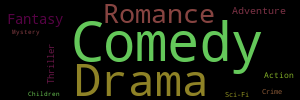
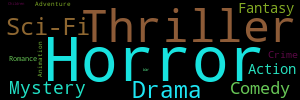
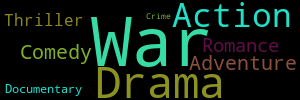
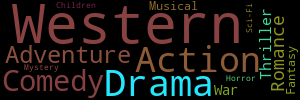
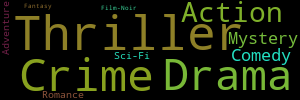
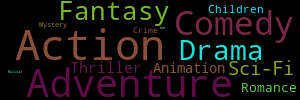
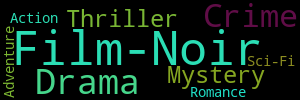
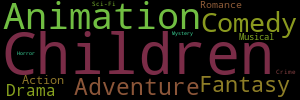
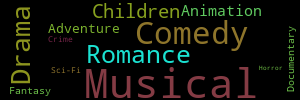
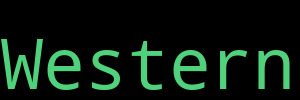
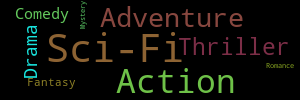
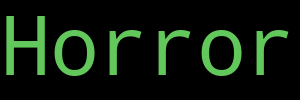
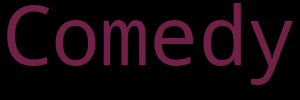
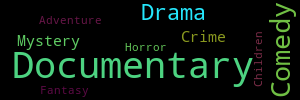

In [22]:
kmeans_ = clstr.kmeans_init(acm_.row_coord_, 16)

jup.display_html("<b>genres ACM</b> - Visualisation dimensions (non exhaustif) KMeans")
clstr.scatter_multiplot(acm_.row_coord_, 
                        num_cols=3, 
                        figsize=(12, 7), 
                        marker_size=1, 
                        labels=kmeans_.labels_)

jup.display_html("<b>genres ACM</b> - Analyse clusters KMeans\n")
clstr.clusters_analysis(acm_.row_coord_, kmeans_.labels_)
clusters_analysis(cluster_data_ohe_df, kmeans_.labels_)

La visualisation par graphe suggère que les *clusters* sont un peu mieux que CAH sans être excellents. Le score Davies Bouldin un peu plus petit ainsi que les scores silhouette un peu plus grands en général corroborent ce constat. En regardant le *clustering* à travers les données d'origine, on peut remarquer une séparation tout de même logique. L'examen détaillé montre :
* Les *clusters* 0 et 2 ainsi que 3 et 13 semblent se chevaucher dans leurs thèmes.
* Le *cluster* 10 semble avoir quelques suggestions hors sujet (ex Woman Is A Woman, non musical).

(**Attention les *clusters* et les films peuvent changer selon la quantité de données prises avant l'analyse**)

## genres ACM - DBSCAN

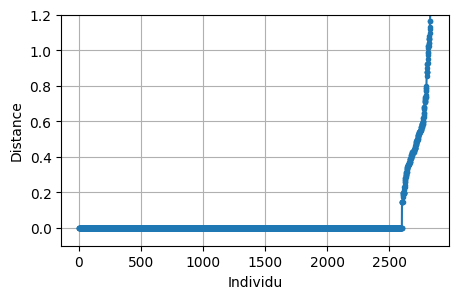

In [23]:
clstr.dbscan_eps_analysis(acm_.row_coord_, 
                          n_neighbors=3,
                          ylim=(-1e-1, 1.2))

DBSCAN optimal parameters
eps: 0.300001
min_samples: 3
silhouette score: 0.7869
# clusters: 165 + ouliers


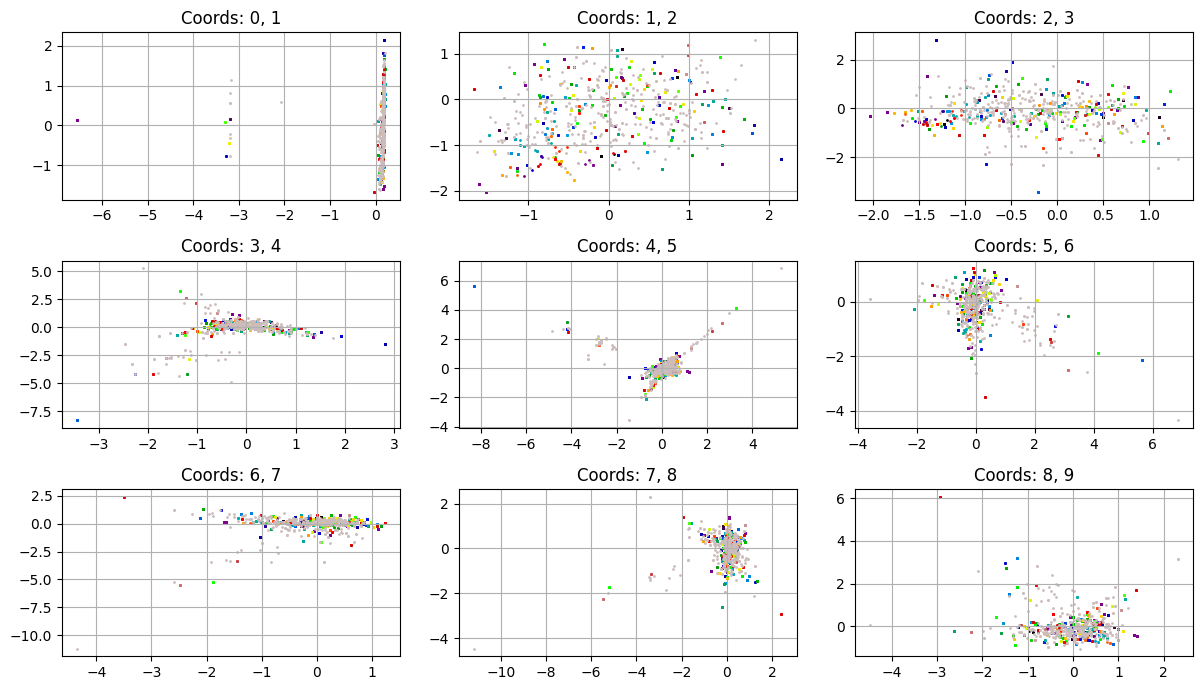

Davies Bouldin score: 1.1918

Silhouette score: 0.7869
Silhouette score par cluster
[1.0, 0.8927, 1.0, 1.0, 1.0, 0.8216, 1.0, 1.0, 0.8543, 1.0, 1.0, 1.0, 0.7966, 1.0, 1.0, 0.7144, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7935, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8277, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7794, 1.0, 1.0, 1.0, 1.0, 0.7228, 0.8562, 1.0, 0.5438, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8636, 0.6584, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8751, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5002, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7391, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7865, 1.0, 1.0, 1.0, 1.0, 0.8545, 1.0, 0.7747, 0.6173, 1.0, 1.0, 0.5826, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6855, 1.0, 1.0, 0.6207, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.7248]




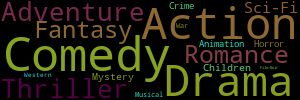
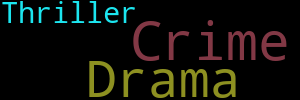
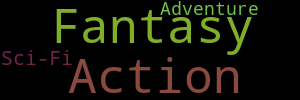
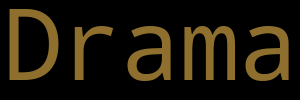
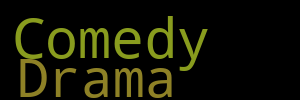
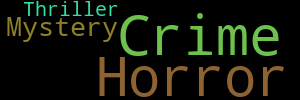
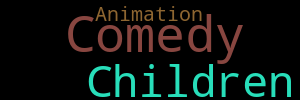
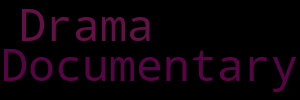
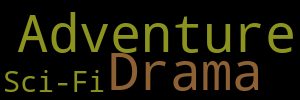
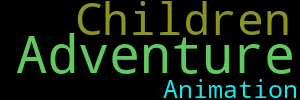

In [24]:
#
# etape longue (~40 secondes) sans feedback visuel; soyez patient
#
eps_, min_samples_ = clstr.dbscan_parameters_analysis(acm_.row_coord_, 
                                                      eps_range=np.arange(1e-6, 0.5, 0.05),
                                                      min_samples_range=range(3, 10))
dbscan_ = clstr.dbscan_init(acm_.row_coord_, eps_, min_samples_)

jup.display_html("<b>genres ACM</b> - Visualisation dimensions (non exhaustif) DBSCAN")
clstr.scatter_multiplot(acm_.row_coord_, 
                        num_cols=3, 
                        figsize=(12, 7), 
                        marker_size=1, 
                        labels=dbscan_.labels_)

jup.display_html("<b>genres ACM</b> - Analyse clusters DBSCAN (HEAD)\n")
clstr.clusters_analysis(acm_.row_coord_, dbscan_.labels_)

clusters_analysis(cluster_data_ohe_df, dbscan_.labels_, head_count=10)

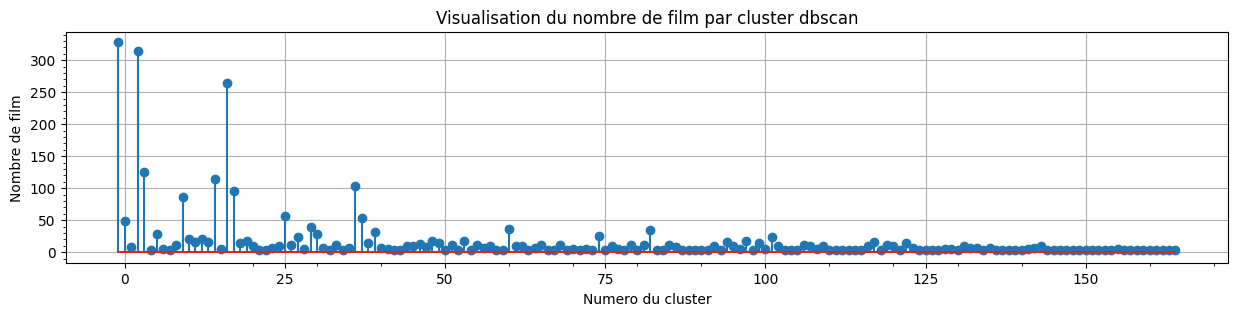

In [25]:
#visualisation du nombre de film par cluster dbscan
unique, counts = np.unique(dbscan_.labels_, return_counts=True)

result = np.column_stack((unique, counts))

fig, ax = plt.subplots(figsize=(15,3))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.stem(unique, counts)
plt.title('Visualisation du nombre de film par cluster dbscan')
plt.xlabel('Numero du cluster')
plt.ylabel('Nombre de film')
plt.grid()
plt.show()

La visualisation par graphe suggère que les *clusters* sont plutôt mal définis, longs et peu compacts. Le score Davies Bouldin est élevé ainsi que les scores silhouette (en général > 0.7). Les scores silhouette s'expliquent par la grande quantité de *clusters*; plus il y en a, plus les clusters vont se coller aux données. 165 nous apparait tout de même excessif. L'examen du *clustering* à travers les données d'origine montre que leurs contenu est logique. Par contre, la taille des *clusters* est très débalancée. Il y a une grande quantité de films considérés comme *outliers* (voir groupe -1 sur le graphe).

Nous allons comparer la *clusterization* précédente avec une autre représentation de **genres**. A savoir **genres_tfidf\***. Une analyse en composante principale (PCA) sera utilisée pour réduire la dimentionalité étant donné que cette variable est quantitative. Nous avons quelques réserves à ce propos. D'une part, la PCA demande de centrer chacune des variables. Hors tf-idf requière l'ensemble de celles-ci pour chaque individu; c'est un vecteur. Changer chaque composante indépendamment semble donc contre nature. D'autre part, la grande présence de 0 biaise le centrage. Nous allons donc utiliser **genres_tfidf\*** directement sans d'autres transformations.

## genres_tfidf* PCA

Valeurs propres:
[0.1458 0.1248 0.0728 0.0668 0.0596 0.0531 0.0429 0.038  0.0331 0.0292
 0.0279 0.0257 0.0246 0.0193 0.0174 0.0137 0.0068 0.0033]

Valeurs propres > 1:
[]

Valeurs propres > 1.1548 (saporta):
[]

Variance expliquee %:
[18.1 15.5  9.1  8.3  7.4  6.6  5.3  4.7  4.1  3.6  3.5  3.2  3.1  2.4
  2.2  1.7  0.8  0.4]

Variance expliquee cumul. %:
[ 18.1  33.6  42.7  51.   58.4  65.   70.3  75.   79.1  82.8  86.2  89.4
  92.5  94.9  97.   98.7  99.6 100. ]



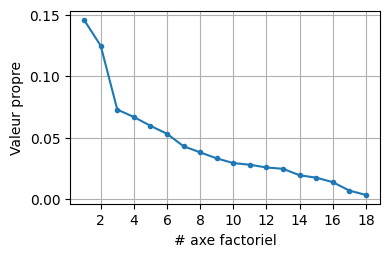

In [26]:
pca_std_df = pd.DataFrame(genres_tfidf_df, 
                          index=genres_tfidf_df.index,
                          columns=genres_tfidf_df.columns)

clstr.pca_analysis(pca_std_df)

La règle de Kaiser ne permet pas de déterminer le nombre d'axes factoriels à choisir. Le coude suggère 3 axes pour une variance expliquée de \~42%. Cependant, nous gardons 6 axes pour avoir une variance expliquée supérieure à 60% (\~65%).

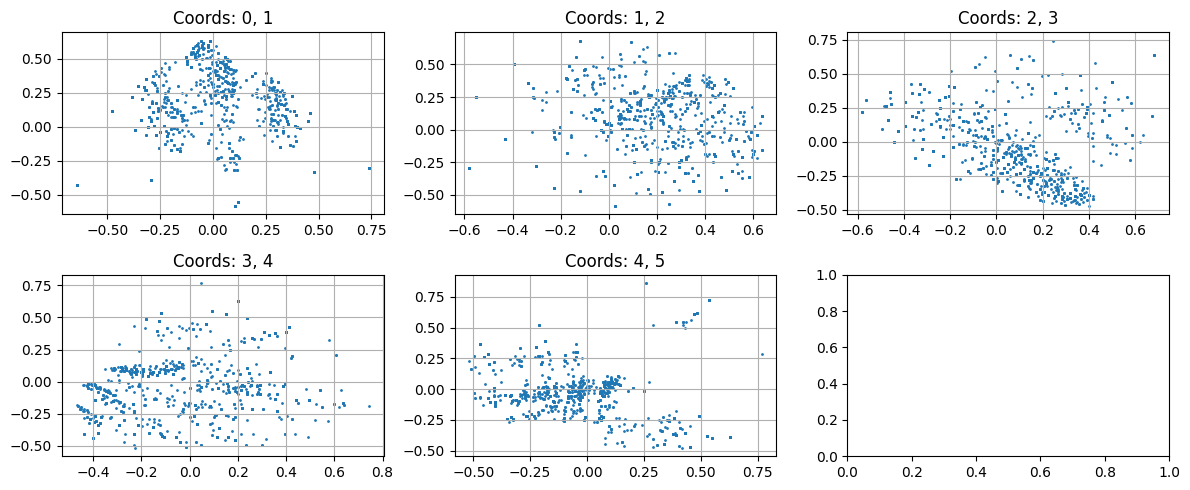

In [27]:
pca_ = clstr.pca_init(pca_std_df, 6)

jup.display_html("<b>genres_tfidf PCA</b> - Visualisation dimensions (non exhaustif)")
clstr.scatter_multiplot(pca_.row_coord_, num_cols=3, figsize=(12, 5), marker_size=1)

On remarque certaines structures qui se détachent nettement ce qui laisse présager que le *clustering* est possible. Les formes non globulaires suggèrent que KMeans ne sera pas énormément plus efficace que CAH mais elles sont tout de même plus nettes que CAH. La densité des points laisse présager que DBSCAN pourrait être un bon choix.

## genres_tfidf* PCA - CAH

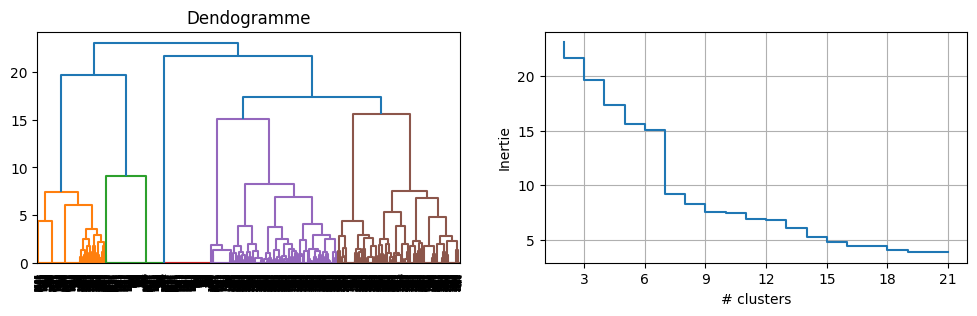

In [28]:
#
# etape tres longue (~40 secondes) sans feedback visuel; soyez patient
#
clstr.cah_analysis(pca_.row_coord_, figsize=(12, 3))

On remarque un coude à 7 *clusters* et si on coupe à la moitié du gain maximum en inertie entre les *clusters*, soit environ 15, on obtient aussi 7 *clusters* .

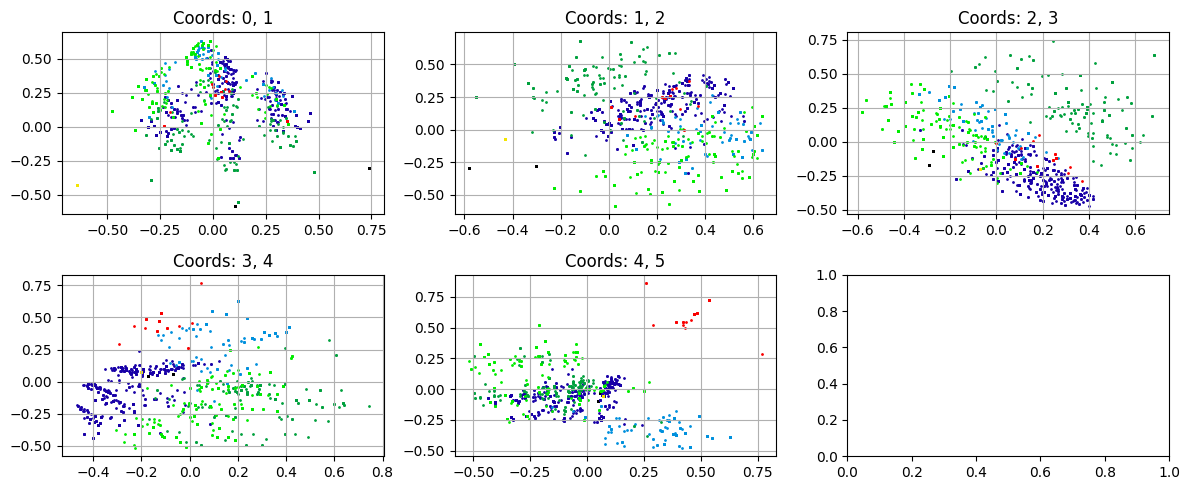

Davies Bouldin score: 0.8954

Silhouette score: 0.4612
Silhouette score par cluster
[0.6556, 0.2803, 0.4868, 0.3627, 0.2154, 1.0, 0.8654]




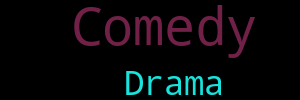
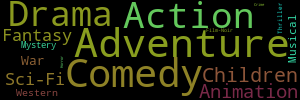
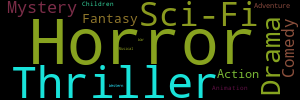
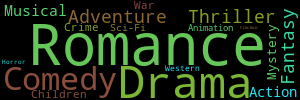
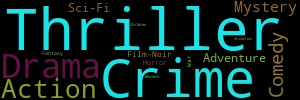
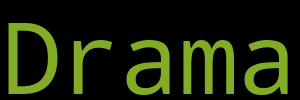
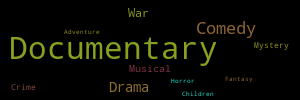

In [29]:
cah_ = clstr.cah_init(pca_.row_coord_, 7)

jup.display_html("<b>genres_tfidf PCA</b> - Visualisation "
                 "dimensions (non exhaustif) CAH")
clstr.scatter_multiplot(pca_.row_coord_, 
                        num_cols=3, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=cah_.labels_)

jup.display_html("<b>genres_tfidf PCA</b> - Analyse clusters CAH\n")
clstr.clusters_analysis(pca_.row_coord_, cah_.labels_)
clusters_analysis(cluster_data_ohe_df, cah_.labels_)

Le score Davies Bouldin est grand et les scores silhouette sont relativement petits (autour de 0.4 en général) ce qui suggère des *clusters* plus ou moins bien définis. Ceci corrobore la visualisation des dimensions où on remarque des zones mais sans frontière franche. 

Examiner les *clusters* dans les données d'origines semble suggérer qu'ils forment une division logique. Cependant, les *cluster* 0 et 5 sont très peu discriminants. 

## genres_tfidf* PCA - KMeans

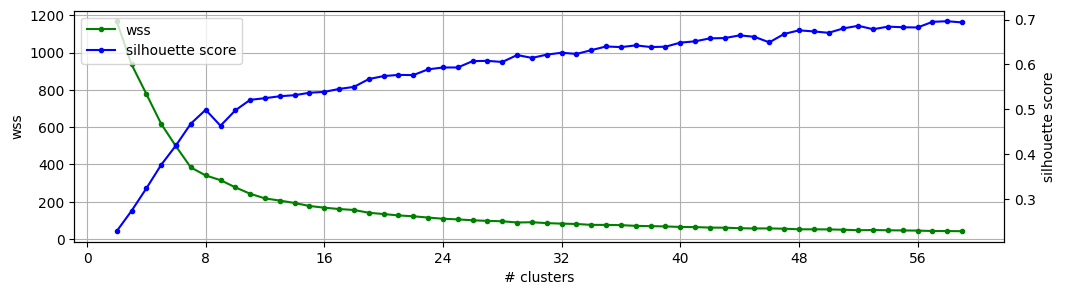

In [30]:
#
# etape longue (~20 secondes) sans feedback visuel; soyez patient
#
clstr.kmeans_analysis(pca_.row_coord_, 
                      clusters_range=range(2, 60),
                      n_init=5, # pour accelerer le traitement
                      figsize=(12, 3))

Le score silhouette va systématiquement en augmentant. Nous devons donc utiliser la méthode du coude avec l'inertie (wss) pour déterminer un nombre raisonnable de *clusters*. Nous estimons que la zone du coude se situe entre 7 et 10 *clusters*. Nous en prenons 10; premier point du coude où se trouve un plateau dans le score silhouette.

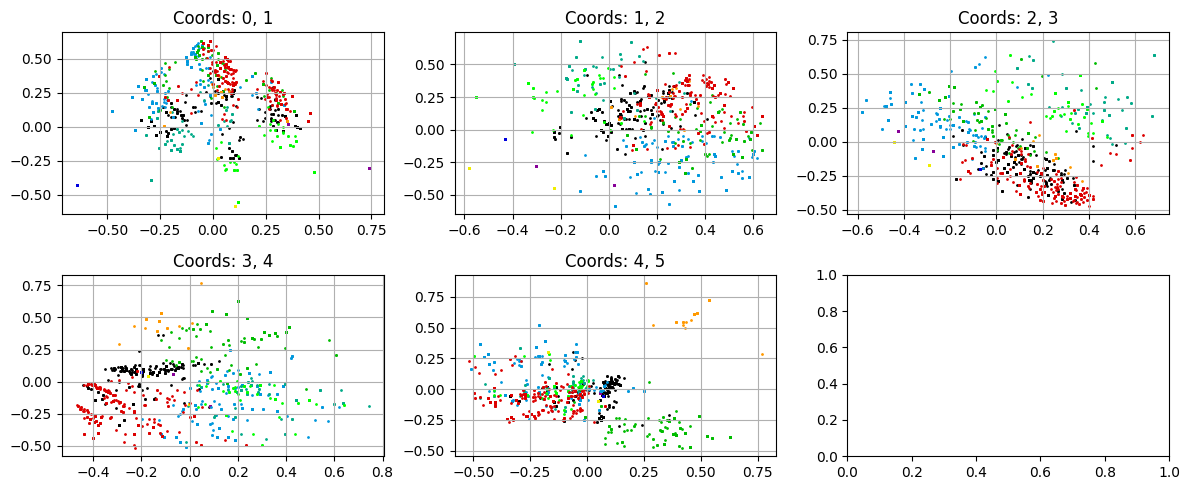

Davies Bouldin score: 0.9172

Silhouette score: 0.5076
Silhouette score par cluster
[0.1807, 0.8255, 1.0, 0.296, 0.4959, 0.4586, 0.4827, 0.9024, 0.8536, 0.2539]




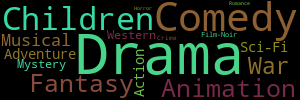
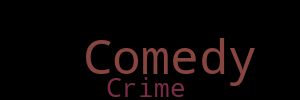
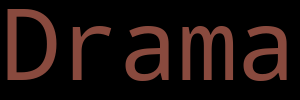
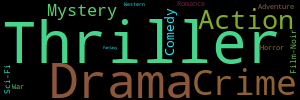
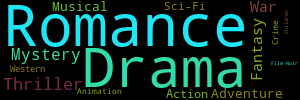
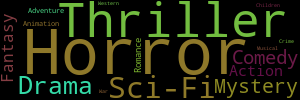
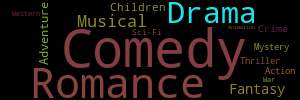
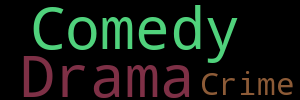
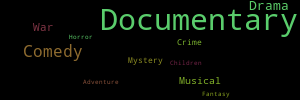
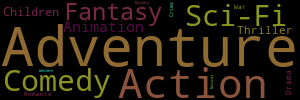

In [31]:
kmeans_ = clstr.kmeans_init(pca_.row_coord_, 10)

jup.display_html("<b>genres_tfidf PCA</b> - Visualisation dimensions (non exhaustif) KMeans")
clstr.scatter_multiplot(pca_.row_coord_, 
                        num_cols=3, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=kmeans_.labels_)

jup.display_html("<b>genres_tfidf PCA</b> - Analyse clusters KMeans\n")
clstr.clusters_analysis(pca_.row_coord_, kmeans_.labels_)
clusters_analysis(cluster_data_ohe_df, kmeans_.labels_)

La visualisation par graphe suggère que les *clusters* sont un peu mieux que CAH sans être excellent. Le score Davies Bouldin un peu plus petit ainsi que les scores silhouette un peu plus grands en général corroborent ce constat. En regardant le *clustering* à travers les données d'origine, on peut remarquer une séparation tout de même logique. L'examen détaillé montre :
* La présence de Tokyo Tribe (musical) dans le *cluster* 2 semble hors thème
* Le *cluster* 7 semble un peu trop englobant avec romance et war.

(**Attention les *clusters* et les films peuvent changer selon la quantité de données prises avant l'analyse**)

## genres_tfidf* PCA - DBSCAN

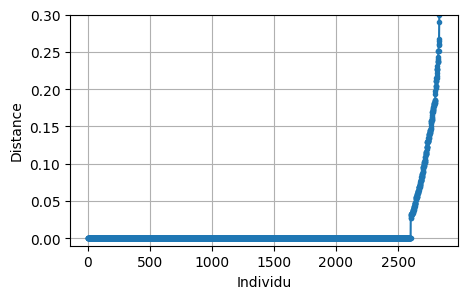

In [32]:
clstr.dbscan_eps_analysis(pca_.row_coord_, 
                          n_neighbors=3,
                          ylim=(-1e-2, 0.3))

DBSCAN optimal parameters
eps: 0.100001
min_samples: 3
silhouette score: 0.7914
# clusters: 146 + ouliers


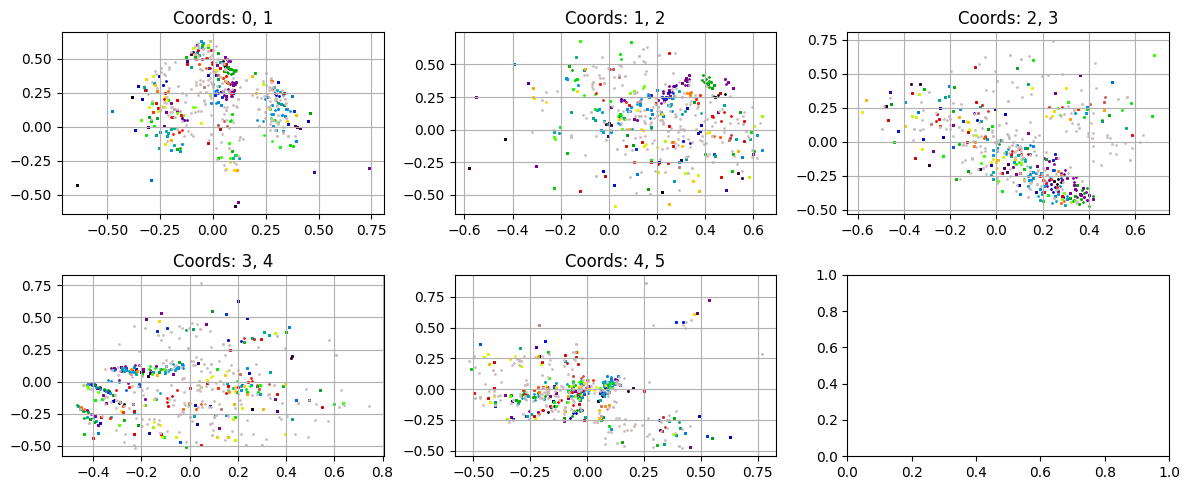

Davies Bouldin score: 0.9843

Silhouette score: 0.7914
Silhouette score par cluster
[1.0, 0.7012, 1.0, 1.0, 0.868, 0.7366, 1.0, 1.0, 0.5991, 1.0, 1.0, 0.9039, 0.388, 1.0, 1.0, 0.7329, 1.0, 0.7579, 1.0, 1.0, 1.0, 1.0, 1.0, 0.593, 1.0, 1.0, 1.0, 0.6848, 1.0, 1.0, 1.0, 1.0, 0.8388, 1.0, 0.7776, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7873, 1.0, 0.0777, 1.0, 0.6553, 0.5337, 0.763, 1.0, 0.6857, 1.0, 0.3173, 1.0, 0.6991, 1.0, 0.5885, 1.0, 1.0, 0.7059, 1.0, 1.0, 1.0, 1.0, 0.9195, 1.0, 1.0, 1.0, 0.5463, 1.0, 1.0, 1.0, 0.6509, 0.8282, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7125, 1.0, 1.0, 0.6692, 1.0, 0.6954, 1.0, 1.0, 1.0, 0.7519, 1.0, 0.7377, 1.0, 0.6275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6388, 1.0, 1.0, 0.8853, 1.0, 0.8681, 0.6539, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8484, 0.847, 0.8583, 0.8005, 1.0, 0.588, 0.5329, 0.7366, 1.0, 1.0, 1.0, 1.0, 0.4537, 1.0, 1.0, 1.0, 0.6884, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5036, 0.5947, 1.0, 1.0, 0.8135, -0.6758]




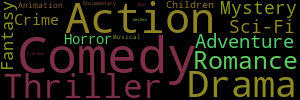
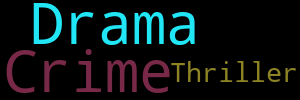
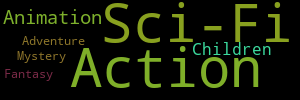
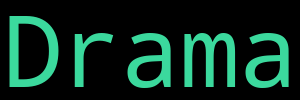
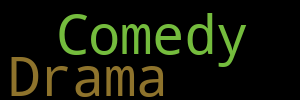
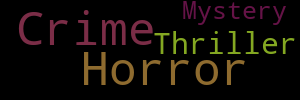
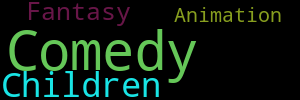
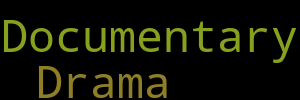
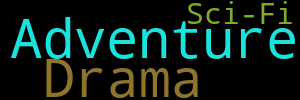
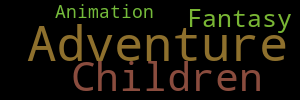

In [33]:
#
# etape longue (~40 secondes) sans feedback visuel; soyez patient
#
eps_, min_samples_ = clstr.dbscan_parameters_analysis(pca_.row_coord_, 
                                                  eps_range=np.arange(1e-6, 0.2, 0.05),
                                                  min_samples_range=range(3, 10))
dbscan_ = clstr.dbscan_init(pca_.row_coord_, eps_, min_samples_)

jup.display_html("<b>genres_tfidf PCA </b> - Visualisation "
                 "dimensions (non exhaustif) DBSCAN")
clstr.scatter_multiplot(pca_.row_coord_, 
                        num_cols=3, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=dbscan_.labels_)

jup.display_html("<b>genres_tfidf PCA </b> - Analyse clusters DBSCAN (HEAD)\n")
clstr.clusters_analysis(pca_.row_coord_, dbscan_.labels_)

clusters_analysis(cluster_data_ohe_df, dbscan_.labels_, head_count=10)

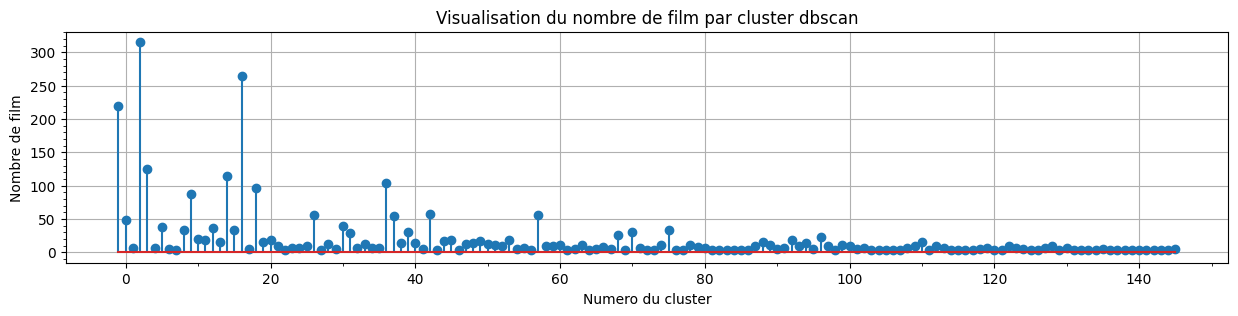

In [34]:
#visualisation du nombre de film par cluster dbscan
unique, counts = np.unique(dbscan_.labels_, return_counts=True)

result = np.column_stack((unique, counts))

fig, ax = plt.subplots(figsize=(15, 3))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.stem(unique, counts)
plt.title('Visualisation du nombre de film par cluster dbscan')
plt.xlabel('Numero du cluster')
plt.ylabel('Nombre de film')
plt.grid()
plt.show()


Grand score Davies Bouldin. Très grands scores silhouette en général (> 0.6) qui peut être expliqué par la grande quantité de *clusters* (colle trop aux données). La visualisation ne montre pas de zones bien définies. Les *clusters* sont très débalancés et il y a beaucoup de films considérés comme *outliers* mais moins que le dbscan avec acm-genre. L'examen des *clusters* dans les données d'origine montre que ceux-ci sont très peu discriminant. Par exemple *clusters* 0, 1 et 2 ou *clusters* 7 et 8. 

Notre prochaine étape est d'analyser une autre technique de réduction de dimension. En effet, la forte présence de 0 n'est pas sans influencer les résultats précédents. Nous allons essayer [TruncatedSVD](https://tinyurl.com/578bxnnt).

## genres TruncatedSVD

In [35]:
#
# utilitaires pour analyser TruncatedSVD
#
def truncated_svd_init(data, n_components):
    return TruncatedSVD(n_components=n_components).fit(data)

def truncated_svd_analysis(data, figsize=(4, 2.5)):
    model = truncated_svd_init(data, data.shape[1])
    coords = model.transform(data)
    
    explained_variance_ratio_ = np.cumsum(model.explained_variance_ratio_)

    plt.figure(figsize=figsize)
    plt.plot(range(1, explained_variance_ratio_.shape[0] + 1), explained_variance_ratio_, marker=".")
    plt.grid(True)
    plt.xlabel("# axe factoriel")
    plt.ylabel("variance expliquée cum.")
    plt.show()

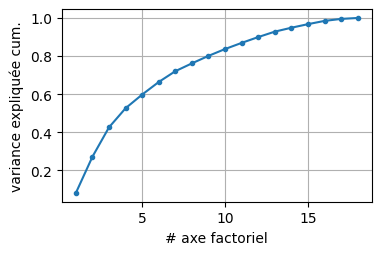

In [36]:
truncated_svd_analysis(cluster_data_ohe_df)

Nous gardons 8 axes factoriels afin de pouvoir comparer avec l'ACM. ~75% variance expliquée et à droite du coude (environ à 4 ou 5 axes).

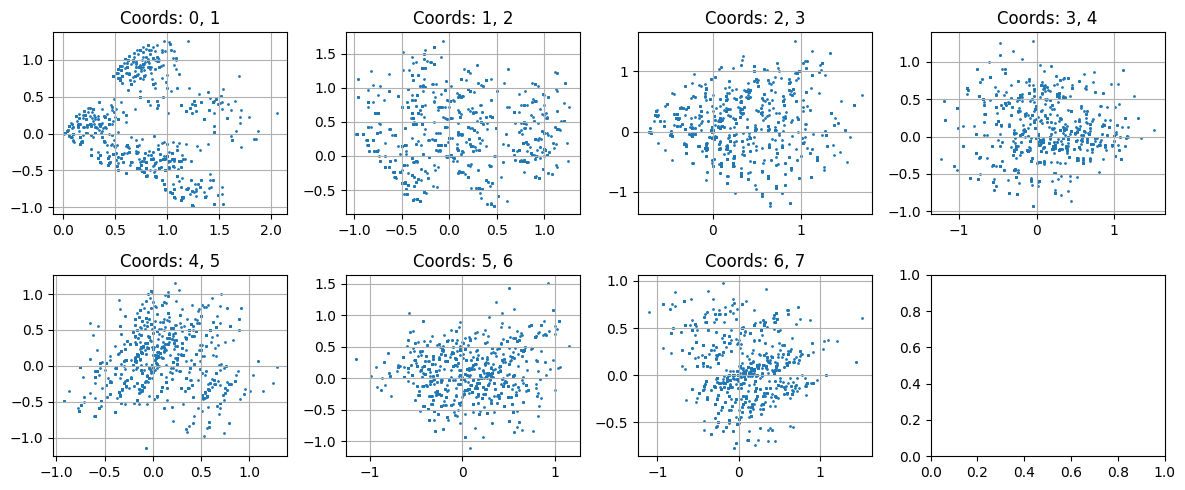

In [37]:
tsvd_coords = truncated_svd_init(cluster_data_ohe_df, 8).transform(cluster_data_ohe_df)

clstr.scatter_multiplot(tsvd_coords,
                        num_cols=4,
                        figsize=(12, 5),
                        marker_size=1)

On remarque certaines structures qui se détachent ce qui laisse présager que le *clustering* pourrait avoir un effet. La forme non globulaire suggère que KMeans ne sera pas énormément plus efficace que CAH. La densité des points laisse présager que DBSCAN ne sera pas un grand succès non plus.

## genres TruncatedSVD - CAH

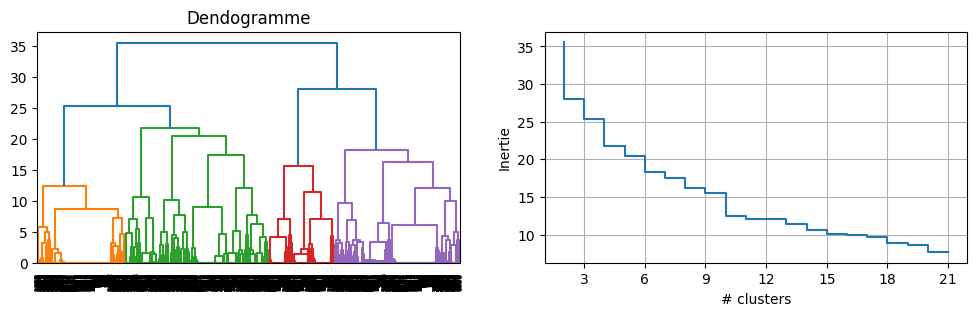

In [38]:
#
# etape longue (~45 minutes) sans feedback visuel; soyez patient
#
clstr.cah_analysis(tsvd_coords, figsize=(12, 3))

Coude à 10 *clusters*. Faible coudes à 12 et 17 *clusters*. Quand on coupe à la moitié du gain maximum en inertie entre les *clusters*, soit environ 17, on obtient environ 9 *clusters* . Nous allons garder 10 parce que les coudes à 12 et 17 ne nous apparaissent pas assez francs par rapport à celui de 10. 

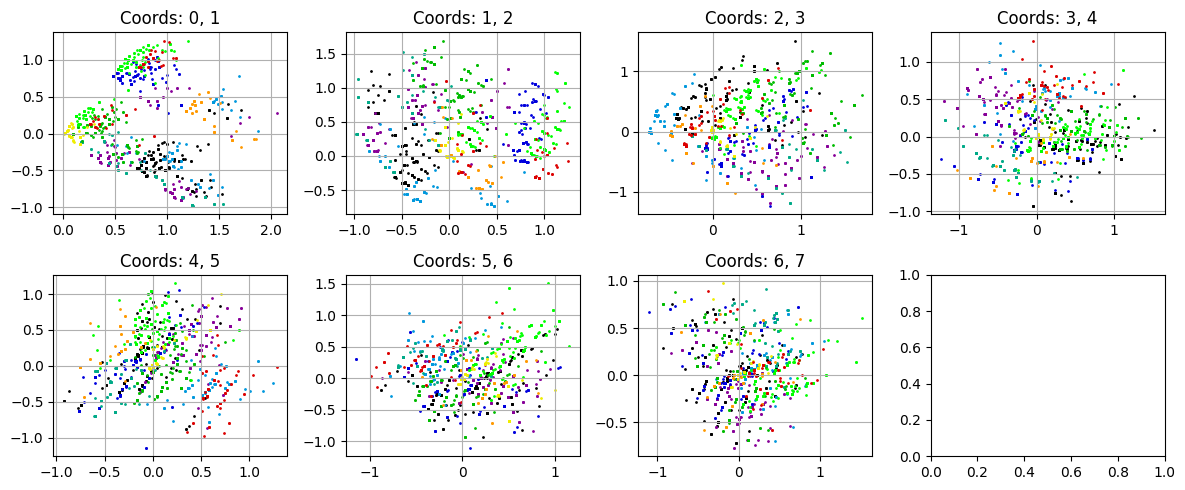

Davies Bouldin score: 1.1511

Silhouette score: 0.3849
Silhouette score par cluster
[0.4751, 0.1482, 0.4563, 0.3627, 0.224, 0.1922, 0.1218, 0.598, 0.6492, 0.5049]




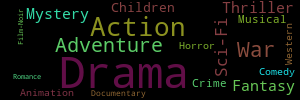
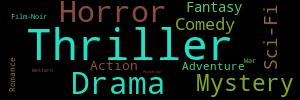
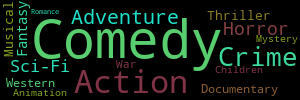
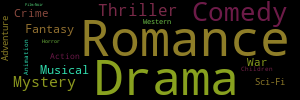
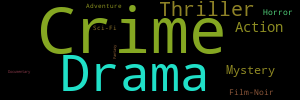
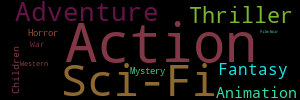
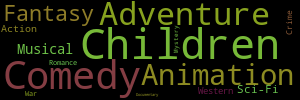
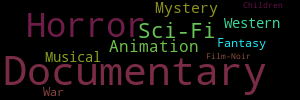
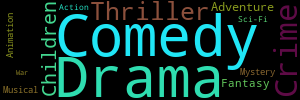
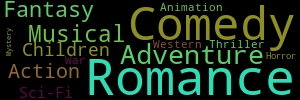

In [39]:
cah_ = clstr.cah_init(tsvd_coords, 10)

jup.display_html("<b>genres TruncatedSVD</b> - Visualisation "
                 "dimensions (non exhaustif) CAH")
clstr.scatter_multiplot(tsvd_coords, 
                        num_cols=4, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=cah_.labels_)

jup.display_html("<b>genres TruncatedSVD</b> - Analyse clusters CAH\n")
clstr.clusters_analysis(tsvd_coords, cah_.labels_)
clusters_analysis(cluster_data_ohe_df, cah_.labels_)

Les *clusters* nous apparaissent mal définis. Le score Davies Bouldin est relativement grand. Les scores silhouette sont en général petits (< 0.5) même si quelques uns sont au dessus. La visualisation des coordonnées réduites ne montre pas non plus de zones bien délimitées. Beaucoup de *clusters* projetés dans les données d'origine ne semblent pas très homogènes. 
Par exemple *cluster* 3 avec Miss Sloane (drama) vs Salem's lot (horror) et *cluster* 4 avec Intersellar (Sci-Fi) vs Blue Planet II (documentary).

En comparant avec ACM, TruncatedSVD a permis de réduire davantage la dimentionalité pour un nombre de *clusters* similaires. Leur composition, bien que différente, est un peu moins ciblée en général et souffre de problèmes similaires (individus "*outliers*").

## genres TruncatedSVD - KMeans

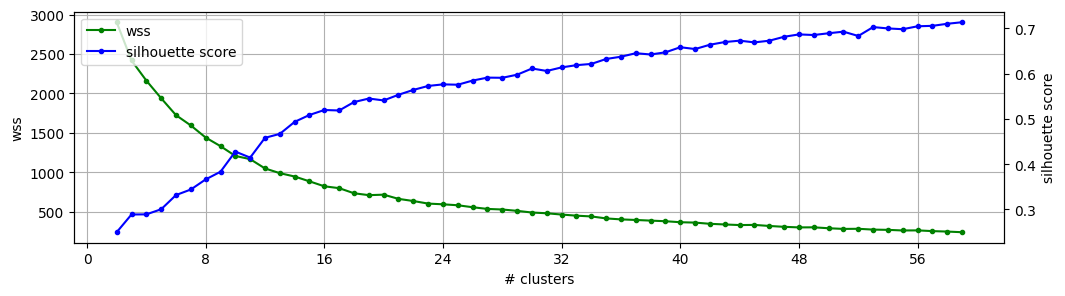

In [40]:
#
# etape longue (~20 secondes) sans feedback visuel; soyez patient
#
clstr.kmeans_analysis(tsvd_coords, 
                      clusters_range=range(2, 60),
                      n_init=5, # pour accelerer le traitement
                      figsize=(12, 3))

Le score silhouette va systématiquement en augmentant. Nous devons donc utiliser la méthode du coude avec l'inertie (wss) pour déterminer un nombre raisonnable de *clusters*. Nous estimons que la zone du coude se situe entre 7 et 10 *cluster*. Nous en prenons donc 10; aucun maximum ou plateau dans score silhouette mais minimum dans inertie.

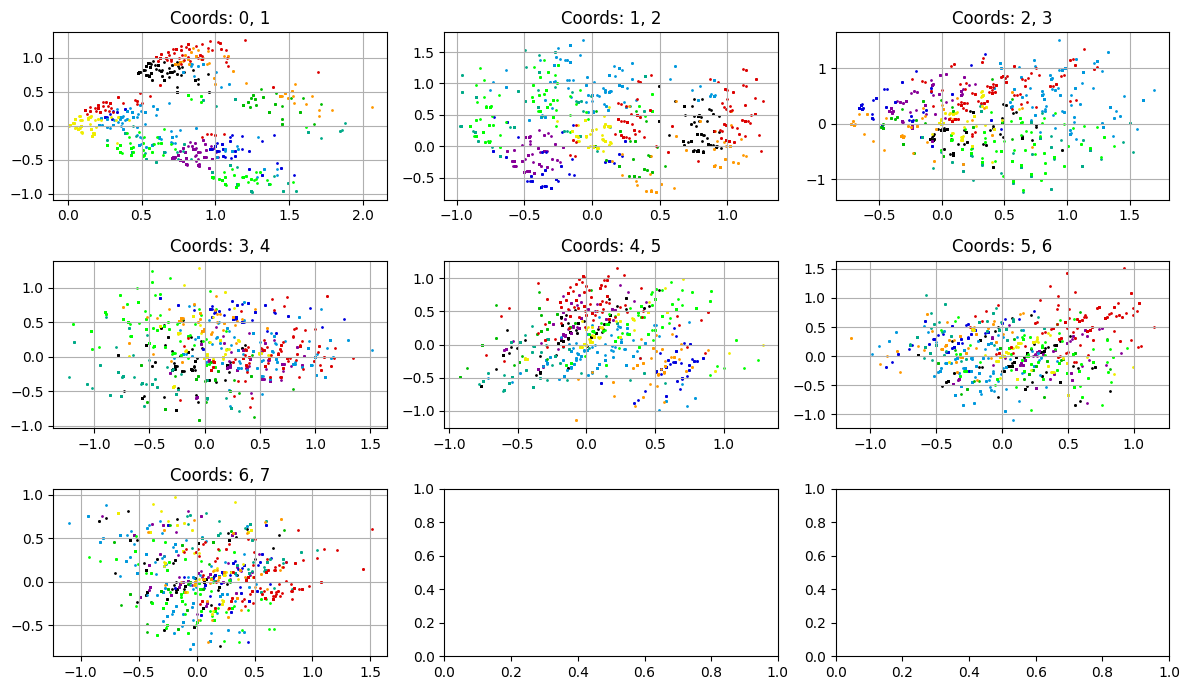

Davies Bouldin score: 1.0804

Silhouette score: 0.4299
Silhouette score par cluster
[0.5651, 0.6002, 0.5675, 0.1557, 0.2339, 0.6634, 0.16, 0.4849, 0.4026, 0.1644]




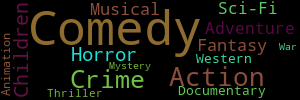
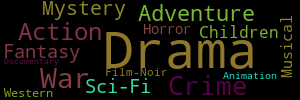
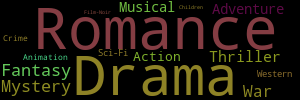
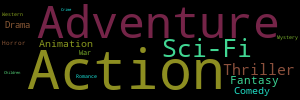
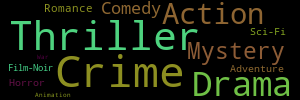
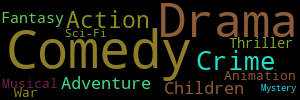
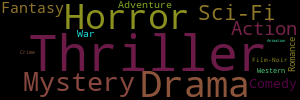
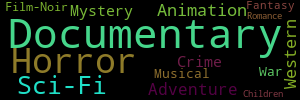
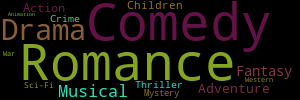
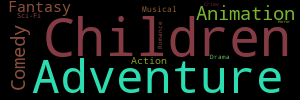

In [41]:
kmeans_ = clstr.kmeans_init(tsvd_coords, 10)

jup.display_html("<b>genres TruncatedSVD</b> - Visualisation "
                 "dimensions (non exhaustif) KMeans")
clstr.scatter_multiplot(tsvd_coords, 
                        num_cols=3, 
                        figsize=(12, 7), 
                        marker_size=1, 
                        labels=kmeans_.labels_)

jup.display_html("<b>genres TruncatedSVD</b> - Analyse clusters KMeans\n")
clstr.clusters_analysis(tsvd_coords, kmeans_.labels_)
clusters_analysis(cluster_data_ohe_df, kmeans_.labels_)

Conclusions similaires quant aux scores et visualisations. *Clusters* plus ciblés par contre.

## genres TruncatedSVD - DBSCAN

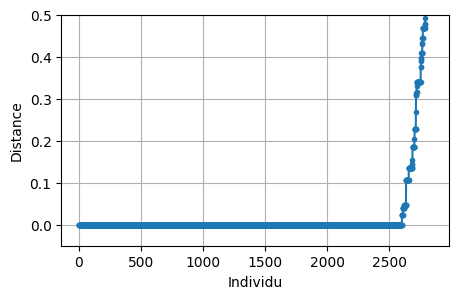

In [42]:
clstr.dbscan_eps_analysis(tsvd_coords, 
                          n_neighbors=3, 
                          ylim=(-0.5e-1, 0.5))

DBSCAN optimal parameters
eps: 0.200001
min_samples: 3
silhouette score: 0.8136
# clusters: 140 + ouliers


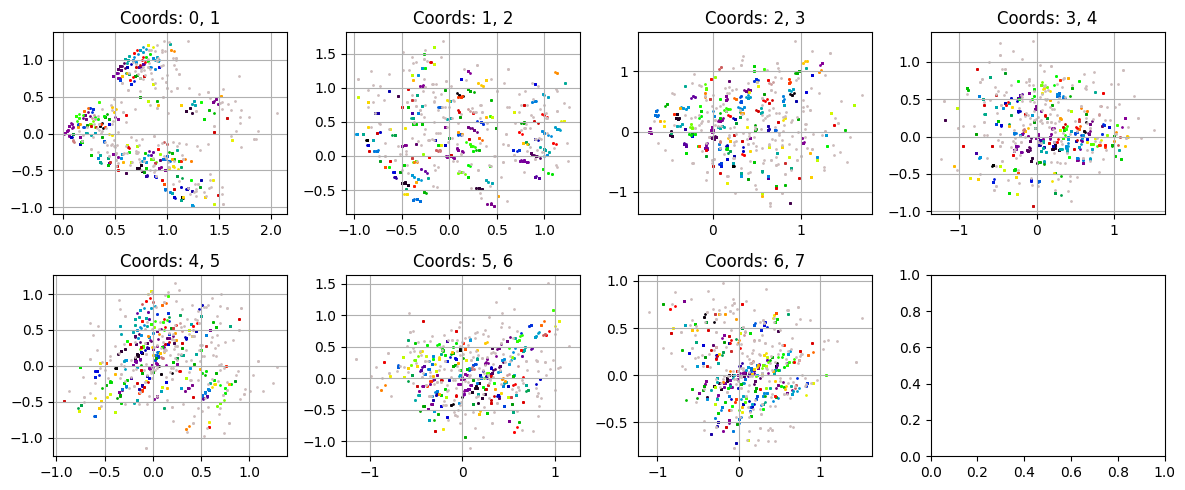

Davies Bouldin score: 1.0722

Silhouette score: 0.8136
Silhouette score par cluster
[0.9951, 0.7421, 0.8934, 0.9754, 1.0, 0.7167, 1.0, 0.7153, 0.9621, 1.0, 0.8678, 0.7998, 0.896, 0.9154, 0.923, 0.969, 0.6792, 0.9549, 1.0, 0.9829, 0.8838, 1.0, 1.0, 0.9501, 0.9931, 0.7181, 0.9828, 1.0, 1.0, 0.9833, 0.992, 0.7872, 1.0, 0.8343, 0.9774, 0.8963, 0.9463, 0.915, 1.0, 0.8933, 0.6621, 1.0, 0.9717, 0.6812, 1.0, 0.8266, 0.7295, 1.0, 0.7146, 1.0, 0.8658, 0.7743, 1.0, 1.0, 1.0, 1.0, 0.9772, 1.0, 1.0, 0.8769, 0.9582, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9703, 1.0, 0.8325, 0.8792, 1.0, 0.9186, 1.0, 1.0, 1.0, 0.8615, 1.0, 0.9691, 1.0, 0.7097, 1.0, 1.0, 1.0, 0.8013, 1.0, 1.0, 0.7924, 1.0, 0.9394, 0.7868, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8561, 1.0, 1.0, 1.0, 0.7942, 0.7572, 1.0, 1.0, 1.0, 0.6857, 0.9562, 1.0, 1.0, 1.0, 1.0, 0.7615, 0.8954, 0.8634, 0.9125, 1.0, 0.8345, 1.0, 1.0, 0.8979, 0.8525, 0.5962, 1.0, 1.0, 0.9355, 1.0, 1.0, 1.0, 0.8433, 1.0, 1.0, 1.0, 0.8368, 1.0, 1.0, 1.0, 0.7948, 0.9004, 0.6177, -0.6548


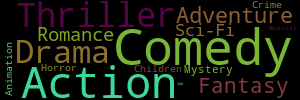
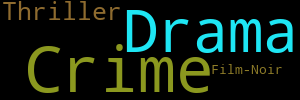
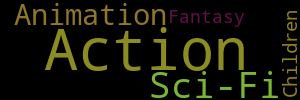
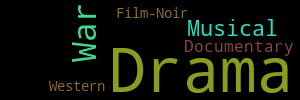
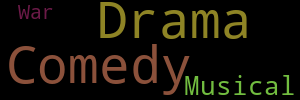
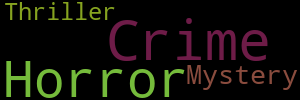
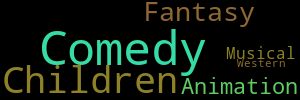
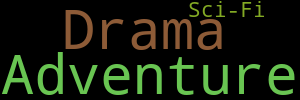
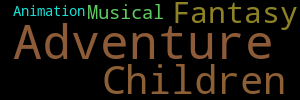
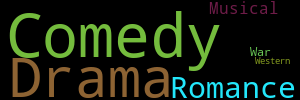

In [43]:
#
# etape longue (~20 secondes) sans feedback visuel; soyez patient
#
eps_, min_samples_ = clstr.dbscan_parameters_analysis(tsvd_coords, 
                                                  eps_range=np.arange(1e-6, 0.4, 0.05),
                                                  min_samples_range=range(3, 10))
dbscan_ = clstr.dbscan_init(tsvd_coords, eps_, min_samples_)

jup.display_html("<b>genres TruncatedSVD</b> - Visualisation "
                 "dimensions (non exhaustif) DBSCAN")
clstr.scatter_multiplot(tsvd_coords, 
                        num_cols=4, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=dbscan_.labels_)

jup.display_html("<b>genres TruncatedSVD</b> - Analyse clusters DBSCAN (HEAD)\n")
clstr.clusters_analysis(tsvd_coords, dbscan_.labels_)

clusters_analysis(cluster_data_ohe_df, dbscan_.labels_, head_count=10)

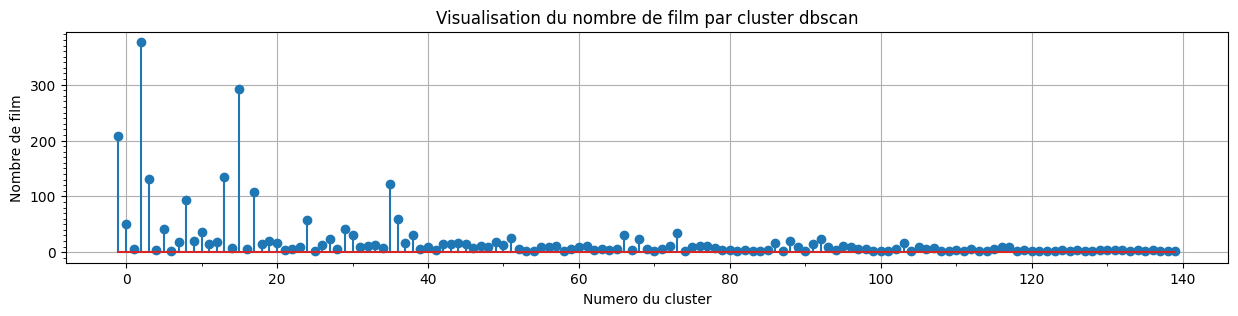

In [44]:
#visualisation du nombre de film par cluster dbscan
unique, counts = np.unique(dbscan_.labels_, return_counts=True)

result = np.column_stack((unique, counts))

fig, ax = plt.subplots(figsize=(15, 3))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.stem(unique, counts)
plt.title('Visualisation du nombre de film par cluster dbscan')
plt.xlabel('Numero du cluster')
plt.ylabel('Nombre de film')
plt.grid()
plt.show()

Nous avons le même constat qu'avec DBSCAN sur l'ACM (beaucoups de *clusters*, en général mal définis, débalancés, beaucoup d'*outliers* si on tient compte des scores et visualisations, division somme toute logique mais avec incohérences).

## genres_tfidf* TruncatedSVD

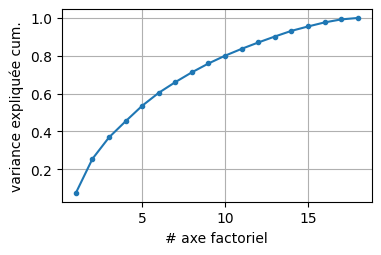

In [45]:
truncated_svd_analysis(genres_tfidf_df)

Nous gardons 8 axes factoriels afin de pouvoir comparer avec l'ACM. ~75% variance expliquée et à droite du coude (environ à 4 ou 5 axes).

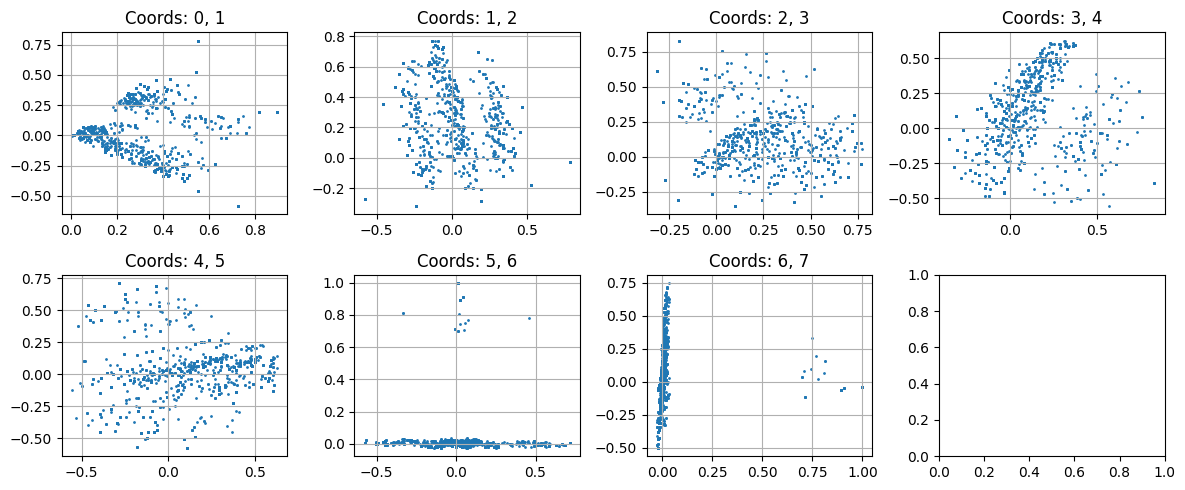

In [46]:
tsvd_coords = truncated_svd_init(genres_tfidf_df, 8).transform(genres_tfidf_df)

clstr.scatter_multiplot(tsvd_coords,
                        num_cols=4,
                        figsize=(12, 5),
                        marker_size=1)

On remarque certaines structures qui se détachent ce qui laisse présager que le *clustering* pourrait avoir un effet. Les structures nettement plus distinctes que **genres** (one hot encoder). La forme non globulaire suggère que KMeans ne sera pas énormément plus efficace que CAH. La densité des points laisse présager que DBSCAN pourrait être intéressant sans être excellent.

## genres_tfidf* TruncatedSVD - CAH

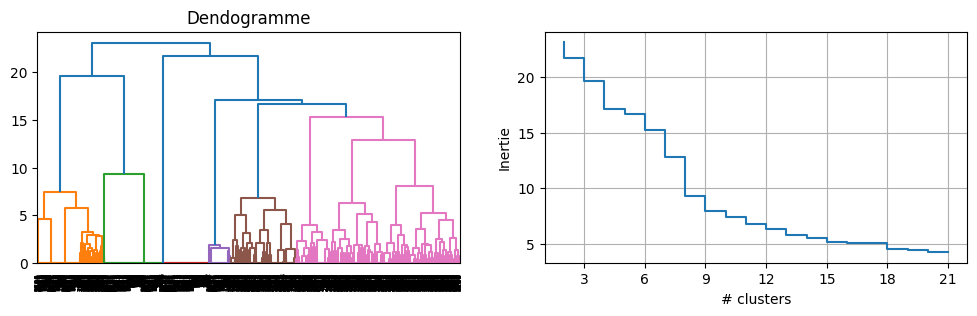

In [47]:
#
# etape longue (~45 secondes) sans feedback visuel; soyez patient
#
clstr.cah_analysis(tsvd_coords, figsize=(12, 3))

Coudes à 4 et 8 clusters. Quand on coupe à la moitié du gain maximum en inertie entre les *clusters*, soit environ 12, on obtient 8 *clusters*. Nous gardons 8 pour avoir plus de *clusters*. 

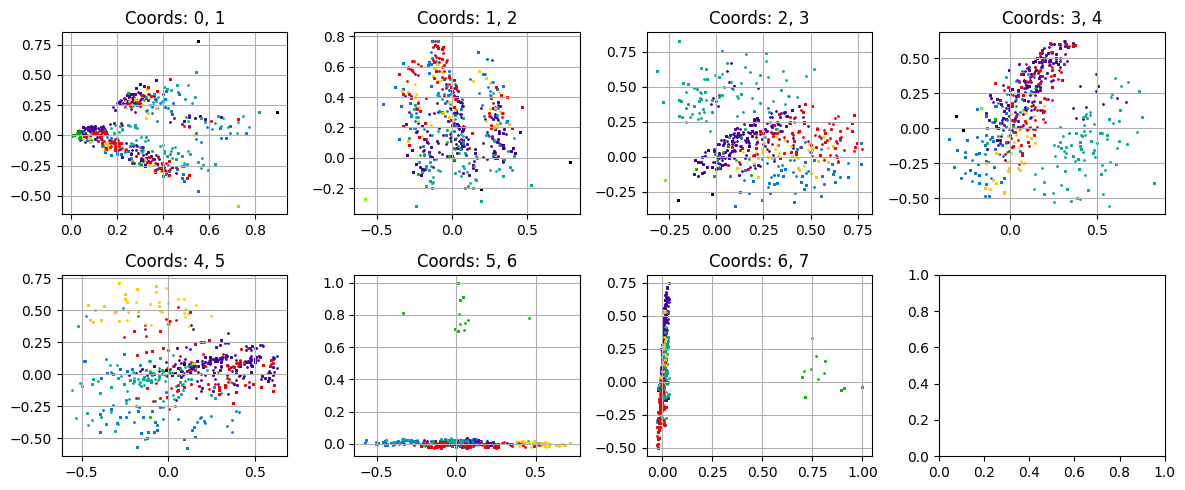

Davies Bouldin score: 1.0005

Silhouette score: 0.4407
Silhouette score par cluster
[0.658, 0.1805, 0.2567, 0.3637, 0.8597, 1.0, 0.4996, 0.1994]




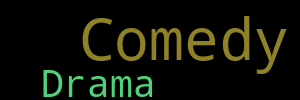
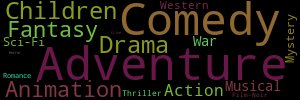
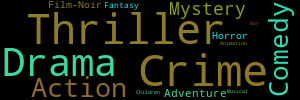
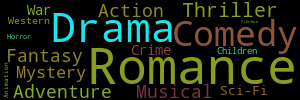
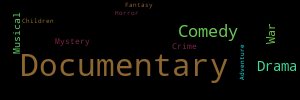
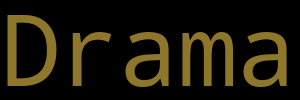
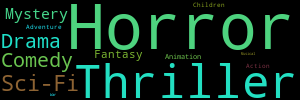
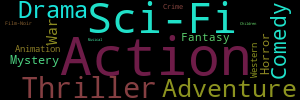

In [48]:
cah_ = clstr.cah_init(tsvd_coords, 8)

jup.display_html("<b>genres_tfidf TruncatedSVD</b> - Visualisation "
                 "dimensions (non exhaustif) CAH")
clstr.scatter_multiplot(tsvd_coords, 
                        num_cols=4, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=cah_.labels_)

jup.display_html("<b>genres_tfidf TruncatedSVD</b> - Analyse clusters CAH\n")
clstr.clusters_analysis(tsvd_coords, cah_.labels_)
clusters_analysis(cluster_data_ohe_df, cah_.labels_)

Même conclusions que précédement. *Clusters* mal définis par scores et visualisation. La projection dans les données d'origine est logique à prime abord mais très peu de *clusters* et la représentation n'est pas excellente:

* *Cluster* 0 (The Lifegard, romance) et 1 semblent se chevaucher
* *Cluster* 5 Très peu discriminant avec Drama
* *Cluster* 7 avec Tokyo Tribe (musical) semble moins homogène

## genres_tfidf* TruncatedSVD - KMeans

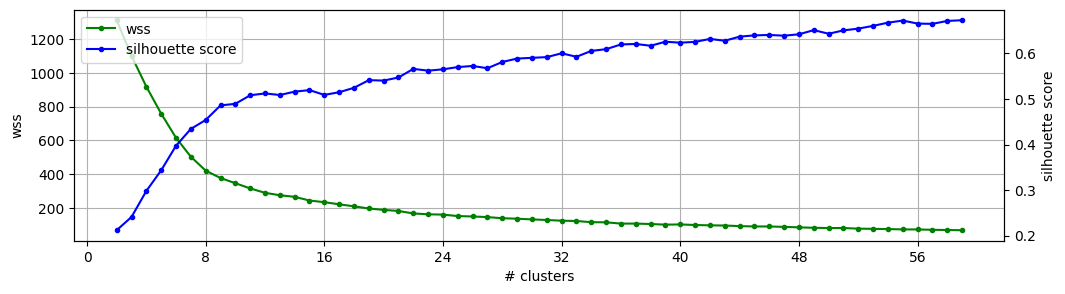

In [49]:
#
# etape longue (~20 secondes) sans feedback visuel; soyez patient
#
clstr.kmeans_analysis(tsvd_coords, 
                      clusters_range=range(2, 60),
                      n_init=5, # pour accelerer le traitement
                      figsize=(12, 3))

Le score silhouette va systématiquement en augmentant. Nous devons donc utiliser la méthode du coude avec l'inertie (wss) pour déterminer un nombre raisonnable de *clusters*. Nous estimons que la zone du coude se situe entre 7 et 11 *clusters*. Nous en prenons 11; maximum score silhouette et inertie minimum.

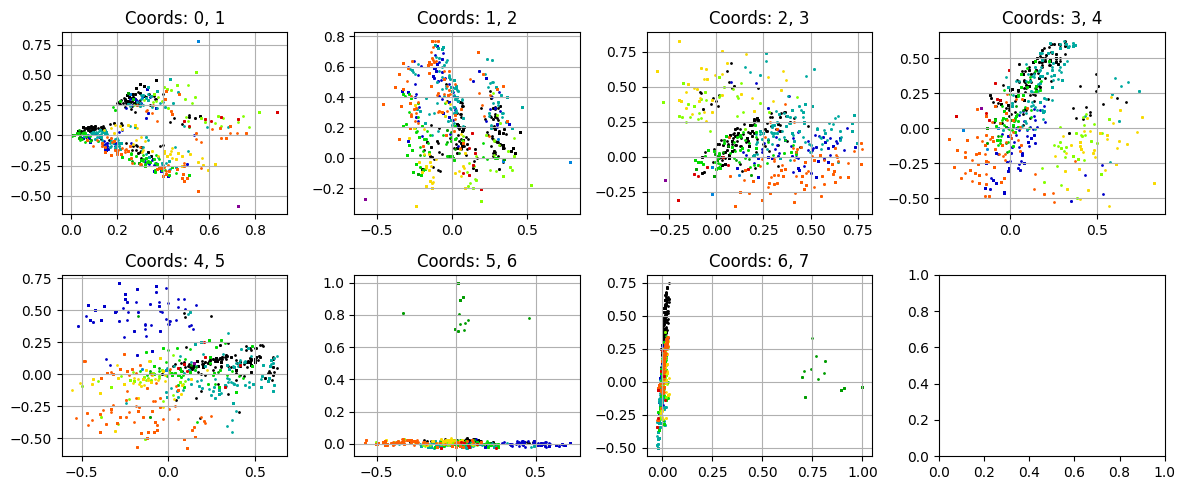

Davies Bouldin score: 0.9138

Silhouette score: 0.511
Silhouette score par cluster
[0.3669, 1.0, 0.4417, 0.935, 0.2036, 0.8524, 0.2461, 0.4836, 0.4827, 0.2155, 0.7959]




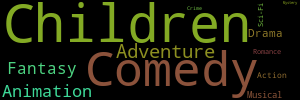
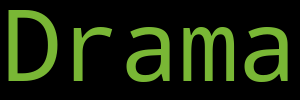
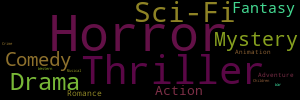
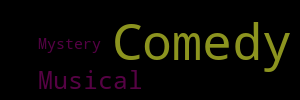
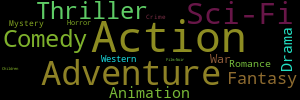
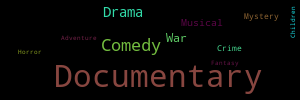
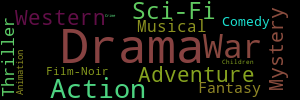
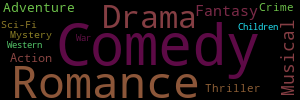
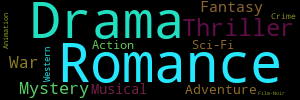
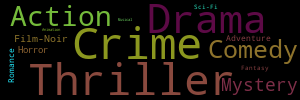
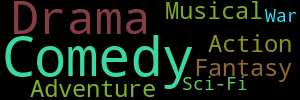

In [50]:
kmeans_ = clstr.kmeans_init(tsvd_coords, 11)

jup.display_html("<b>genres_tfidf PCA</b> - Visualisation dimensions (non exhaustif) KMeans")
clstr.scatter_multiplot(tsvd_coords, 
                        num_cols=4, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=kmeans_.labels_)

jup.display_html("<b>genres_tfidf PCA</b> - Analyse clusters KMeans\n")
clstr.clusters_analysis(tsvd_coords, kmeans_.labels_)
clusters_analysis(cluster_data_ohe_df, kmeans_.labels_)

Même conclusions que précédement. *Clusters* mal définis par scores et visualisations. La projection dans les données d'origine est logique à prime abord mais peu de *clusters* et la représentation n'est pas excellente.

## genres_tfidf* TruncatedSVD - DBSCAN

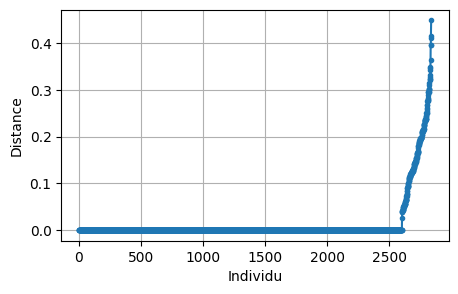

In [51]:
clstr.dbscan_eps_analysis(tsvd_coords, n_neighbors=3)

DBSCAN optimal parameters
eps: 0.15000100000000002
min_samples: 3
silhouette score: 0.7995
# clusters: 156 + ouliers


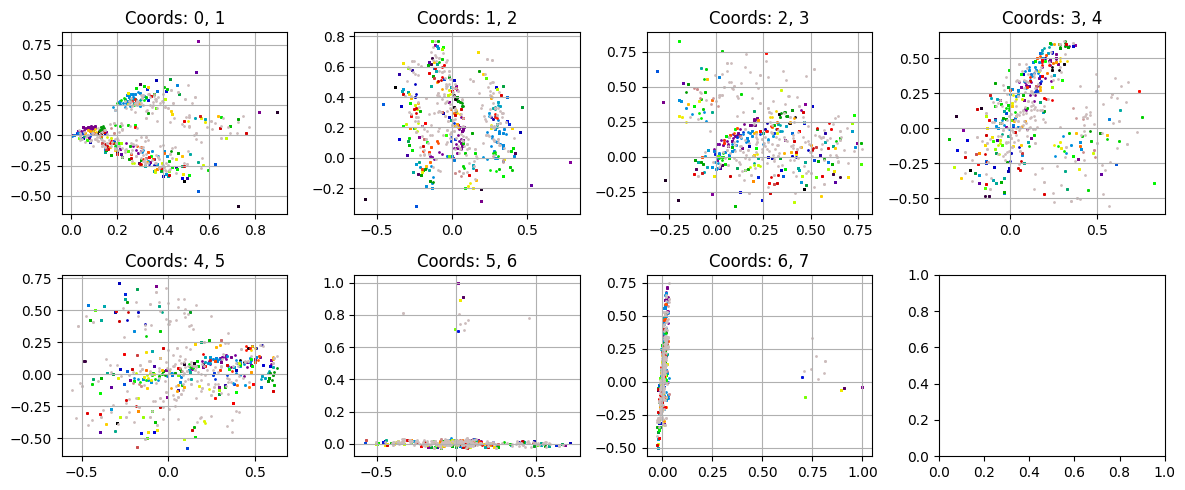

Davies Bouldin score: 0.9622

Silhouette score: 0.7995
Silhouette score par cluster
[1.0, 0.5197, 1.0, 1.0, 0.8547, 1.0, 1.0, 1.0, 0.3041, 1.0, 1.0, 1.0, 0.8121, 1.0, 1.0, 0.9397, 1.0, 0.3511, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6083, 1.0, 1.0, 1.0, 0.5725, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4093, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7294, 1.0, 0.1003, 1.0, 0.4676, 0.6278, 0.6466, 1.0, 0.8424, 1.0, 0.6099, 1.0, 0.7701, 1.0, 1.0, 0.6071, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9257, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5051, 0.8754, 1.0, 0.6512, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4823, 1.0, 1.0, 0.8224, 0.8187, 1.0, 0.5758, 1.0, 1.0, 1.0, 0.8299, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4835, 1.0, 1.0, 0.9003, 1.0, 0.7558, 0.6462, 1.0, 1.0, 1.0, 1.0, 0.5003, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6789, 0.7097, 0.8642, 0.6569, 1.0, 1.0, 0.6114, 1.0, 0.5491, 1.0, 0.7481, 0.5478, 1.0, 1.0, 1.0, 1.0, 0.6316, 1.0, 1.0, 1.0, 1.0, 0.684, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7221, 1.0, 1.0, 1.0, 1.0, 0.5927, 0.5491, -


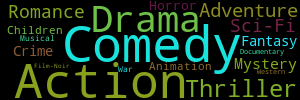
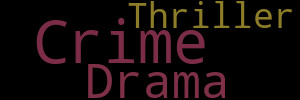
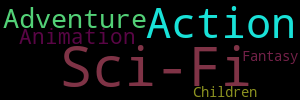
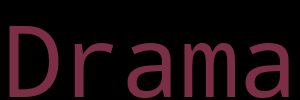
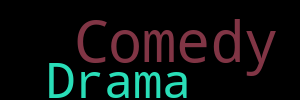
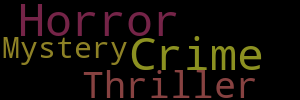
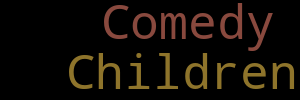
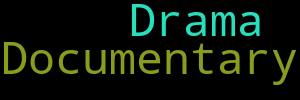
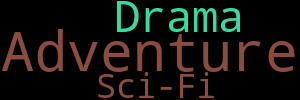
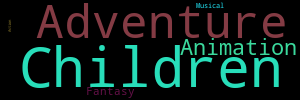

In [52]:
#
# etape longue (~30 secondes) sans feedback visuel; soyez patient
#
eps_, min_samples_ = clstr.dbscan_parameters_analysis(tsvd_coords, 
                                                  eps_range=np.arange(1e-6, 0.3, 0.05),
                                                  min_samples_range=range(3, 10))
dbscan_ = clstr.dbscan_init(tsvd_coords, eps_, min_samples_)

jup.display_html("<b>genres_tfidf TruncatedSVD</b> - Visualisation "
                 "dimensions (non exhaustif) DBSCAN")
clstr.scatter_multiplot(tsvd_coords, 
                        num_cols=4, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=dbscan_.labels_)

jup.display_html("<b>genres_tfidf TruncatedSVD</b> - Analyse clusters DBSCAN (HEAD)\n")
clstr.clusters_analysis(tsvd_coords, dbscan_.labels_)

clusters_analysis(cluster_data_ohe_df, dbscan_.labels_, head_count=10)

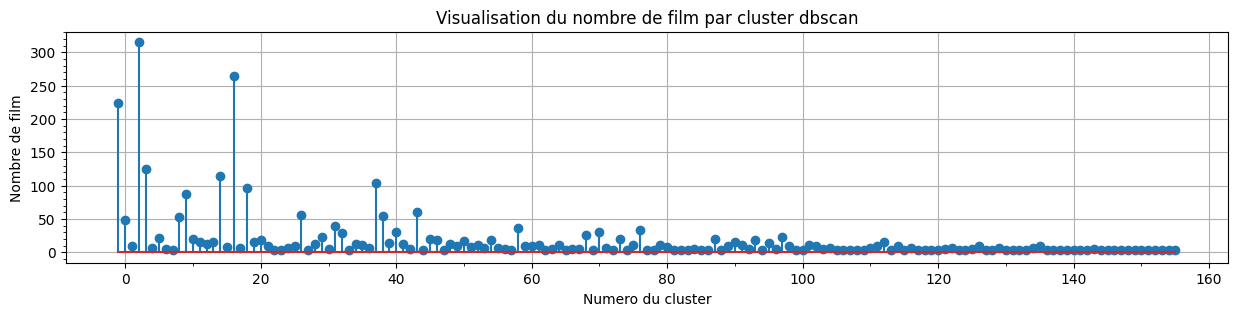

In [53]:
#visualisation du nombre de film par cluster dbscan
unique, counts = np.unique(dbscan_.labels_, return_counts=True)

result = np.column_stack((unique, counts))

fig, ax = plt.subplots(figsize=(15, 3))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.stem(unique, counts)
plt.title('Visualisation du nombre de film par cluster dbscan')
plt.xlabel('Numero du cluster')
plt.ylabel('Nombre de film')
plt.grid()
plt.show()

Nous avons le même constat qu'avec DBSCAN sur l'ACM (beaucoups de *clusters*, en général mal définis, débalancés, beaucoup d'*outliers* si on tient compte des scores et visualisations, division somme toute logique mais avec incohérences).

# Règles associations

In [54]:
rating_df = pd.read_csv("./dataset/ratings_pretraitement.csv", index_col=0)
rating_df = rating_df.notnull()

print("Nombre de user", rating_df.shape[0])
print("Nombre de film", rating_df.shape[1])

Nombre de user 582
Nombre de film 9460


Test pour déterminer le meilleur support pour les règles.

In [55]:
choix_min_support = [0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.25, 0.28, 0.3, 0.4]
print("Nombres d'individus correspondants aux supports:")
print([
      int(choix_min_support[i]*rating_df.shape[0]) for i in range(len(choix_min_support))])

Nombres d'individus correspondants aux supports:
[58, 69, 81, 93, 104, 116, 128, 145, 162, 174, 232]


In [56]:
#Visualisation du nombre d'items frequents vs le support minimum 
num_freq_itemset, freq_itemsets = [], []
for minsup in choix_min_support:
    freq_items = apriori(rating_df, 
                         min_support=minsup,
                         max_len=9, 
                         use_colnames=True)
    freq_itemsets.append(freq_items)
    num_freq_itemset.append(freq_items.shape[0])

result_df = pd.DataFrame({'minsup': choix_min_support, 
                          'num_items': num_freq_itemset, 
                          'itemsets':freq_itemsets})
display(result_df[['minsup','num_items']])

minsup  num_items
0     0.10     115834
1     0.12      21708
2     0.14       5553
3     0.16       1971
4     0.18        877
5     0.20        432
6     0.22        231
7     0.25        109
8     0.28         57
9     0.30         43
10    0.40          6

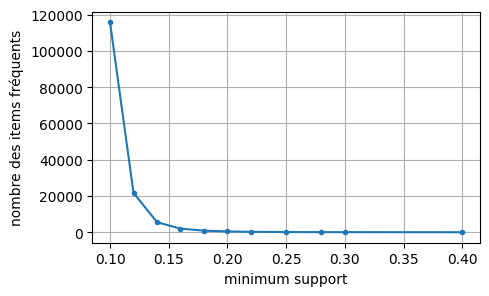

In [57]:
plt.figure(figsize=(5, 3))
plt.plot(result_df.minsup, result_df.num_items, marker=".")
plt.xlabel("minimum support")
plt.ylabel("nombre des items fréquents")
plt.grid(True)
plt.show()

In [58]:
# initialise un petit seuil de confidence 10% afin de trouver maximum de règles
num_rules, rules, min_conf = [], [], 0.1
for f_items in freq_itemsets:
    ar = association_rules(f_items, 
                           metric='confidence',
                           min_threshold=min_conf)
    rules.append(ar.sort_values(by='lift', ascending=False))
    num_rules.append(ar.shape[0])
result_df['num_rules'] = num_rules
result_df['rules'] = rules
result_df[['minsup', 'num_items', 'num_rules']]

minsup  num_items  num_rules
0     0.10     115834    3324598
1     0.12      21708     316452
2     0.14       5553      46808
3     0.16       1971      11038
4     0.18        877       3446
5     0.20        432       1226
6     0.22        231        500
7     0.25        109        168
8     0.28         57         46
9     0.30         43         32
10    0.40          6          0

Nous avons choisi d'aller avec un support minimum de 0.12 car au delà de cela le nombre de règle était très grand.

In [59]:
freq_itemsets = apriori(rating_df, min_support=0.12, max_len=10, use_colnames=True)
display(freq_itemsets.sort_values(by='support', ascending=False))

support                       itemsets
42     0.548110                          (356)
36     0.522337                          (318)
32     0.510309                          (296)
67     0.463918                          (593)
151    0.462199                         (2571)
...         ...                            ...
19275  0.120275  (2028, 1210, 260, 2858, 1196)
13424  0.120275        (6539, 2571, 260, 4306)
13417  0.120275        (3578, 5952, 260, 2571)
3740   0.120275                (50, 296, 1136)
14506  0.120275        (296, 7153, 2959, 1210)

[21708 rows x 2 columns]

In [60]:
regles = association_rules(freq_itemsets, metric="confidence", min_threshold=0.11)
myRegles = regles.loc[:, ['antecedents', 'consequents', 'lift', 'conviction']]

In [61]:
# les films peuvent être présents ou non dans les données selon la sélection

#print("Titre de 2571:", movies_df.loc[2571, "title"])
film_id = np.where(myRegles.antecedents.apply(lambda x: {'2571'}.issubset(x)))
myRegles.iloc[film_id][:20]

antecedents consequents      lift  conviction
101       (2571)         (1)  1.251476    1.157029
283       (2571)        (32)  1.290321    1.131029
443       (2571)        (47)  1.427509    1.271868
569       (2571)        (50)  1.353617    1.216810
725       (2571)       (110)  1.275466    1.217585
849       (2571)       (150)  1.014173    1.007026
1197      (2571)       (260)  1.564564    1.671785
1315      (2571)       (293)  1.555065    1.185528
1467      (2571)       (296)  1.274830    1.401349
1701      (2571)       (318)  1.245475    1.366930
1831      (2571)       (344)  1.095834    1.035714
1991      (2571)       (356)  1.275081    1.500721
2138      (2571)       (364)  1.186053    1.080196
2201      (2571)       (367)  1.174918    1.065283
2257      (2571)       (377)  1.206353    1.088910
2303      (2571)       (380)  0.984618    0.993848
2367      (2571)       (457)  1.099519    1.047827
2459      (2571)       (480)  1.194666    1.145734
2525      (2571)       (500)  1.151828    1.050022
2577      (2571)       (527)  1.316511    1.221527

In [62]:
regles['consequents'].nunique()

a = set()

def testfrozen(v, dest):
  dest.update(set(v))

regles1['antecedents'].apply(testfrozen, dest=a)
print(len(a))

NameError: name 'regles1' is not defined

Les règles d'associations ne couvrent que 178 films sur les 9000 d'origine.

# Conclusion

Nous avons regardé 2 représentations de genres, 2 techniques de réduction de dimension et 3 techniques de *clusterization*.

**genres** ne semble pas avoir d'avantage particulier par rapport à **genres_tfidf\***. TruncatedSVD semble, quant à lui avoir un léger avantage sur la réduction de dimensions par rapport à l'ACM. Nous le recommendons donc étant donné le contexte (beaucoup de 0, aucun besoin de centrage).

KMeans et CAH sont les seules méthodes qui donnent des résultats exploitables. En effet, DBSCAN semble trouver une trop grande quantité de *clusters* pour être utilisable. Sinon, bien que les *clusters* de CAH et KMeans soient logiques, ils ne sont pas excellents. Il y a quelques incohérences dans leurs contenus, leur pouvoir discriminant n'est pas optimal, la représentation de tous les genres ne l'est pas non plus et leur interprétation reste ardue. Finalement, leurs calculs demandent également beaucoup de ressources. 

Les règles d'associations ne semblent pas non plus être une bonne approche pour ce genre de système. Le fait que les utilisateurs n'aient qu'une seule grosse liste de film, l'association entre les grosses listes crée beaucoup de redondance dans les règles, favorisent les films très populaires certes mais limite le nombre de film couvert par celles-ci, nous le voyons avec seulement 178 films couvert sur les 9000. 

Nous pensons donc que le *clustering* n'est pas la méthode la plus adéquate pour un système de recommendations.

*K-nearest neighboor* avec une métrique de similarité nous parait plus juste et beaucoup plus simple. Bien que non montré dans ce notebook, l'ajout de critères additionnels dans le *clustering*, tel que **rating_mode**, augmentent la complexité et la difficulté d'interprétation des résultats ce qui n'est pas le cas avec *K-nearest neighboor*. Voici un exemple illustrant une possible implémentation :

In [ ]:
from sklearn.neighbors import NearestNeighbors

#
# ajout des criteres supplementaires
#
rating_mode_ohe_df = movies_df.rating_mode.astype(str).str.get_dummies()
year_ohe_df = pd.get_dummies(movies_df.year_category)

# noter la facilite d'ajouter/enlever des criteres
data_df = pd.concat([genres_ohe_df, rating_mode_ohe_df, year_ohe_df], axis=1)
# data_df = pd.concat([genres_ohe_df, rating_mode_ohe_df], axis=1)
# data_df = pd.concat([genres_ohe_df], axis=1)

# 
# modele pour faire les requetes de suggestions
# cosine est une mesure de similarite
#
cls = NearestNeighbors(n_neighbors=9, n_jobs=-1, metric="cosine").fit(data_df)

#
# requete
# 
print("Query")
# query = movies_df[ movies_df.title == "Star Wars: Episode VII - The Force Awakens (2015)" ]
query = movies_df[ movies_df.title == "Star Wars: The Last Jedi (2017)" ]    
display(query[["title", "rating_mode", "year_category", "genres"]])

print()

#
# recommandations
#
distances, recommandation_indices = cls.kneighbors( data_df.loc[query.index] )
recommandation_indices = recommandation_indices.flatten()
recommandations = movies_df.iloc[recommandation_indices]
recommandations = recommandations[["title", "rating_mode", "year_category", "genres"]]
recommandations["distance"] = distances.flatten()
recommandations.sort_values(by=["distance", "rating_mode"], 
                            inplace=True, 
                            ascending=[True, False])
print("Recommandations")
display(recommandations)